In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from skimage.morphology import dilation, square 
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.lib import utils
from src.lib import cell_blobs_skimage as blobsutils

In [2]:
def plot_ft_importance(ft_importance, columns):
    fig, ax = plt.subplots(1, figsize=(len(columns)*0.5,  6))
    cmap = cm.YlOrRd
    idx_sorting = ft_importance.argsort()
    sorted_ft_importance = ft_importance[idx_sorting]
    sorted_columns = columns[idx_sorting]

    norm = Normalize(vmin=sorted_ft_importance.min(), vmax=sorted_ft_importance.max())
    ax.bar(sorted_columns, sorted_ft_importance, color=cmap(norm(sorted_ft_importance)))
    ax.set_xticks(sorted_columns)
    ax.set_xticklabels(sorted_columns, rotation=45, ha='right', fontsize=12)
    ax.set_aspect('auto', adjustable='box')

    return fig, ax

In [3]:
df = pd.read_csv('../data/processed/2021-03-29_features.csv', index_col=0)
df.insert(0, 'protein', df.index.str.split("_").str[0])
df.insert(1, 'plate', df.index.str.split("_").str[1])
df.insert(2, 'stimulus', df.index.str.split("_").str[2])
df_negsi = df[(df['protein'] == 'NegsiRNA') & df['stimulus'].isin(['NO', 'NS'])]
X = df_negsi.iloc[:, 3:]
X

white_area_ratio     area_mean      area_std  area_median  \
NegsiRNA_E3_NO          0.297828   9152.662983   5861.016265       8733.0   
NegsiRNA_L2_NS          0.188984  16354.025641  11973.890243      14692.0   
NegsiRNA_H3_NO          0.331324   9066.666667   4624.803328       9137.0   
NegsiRNA_G3_NS          0.239506  12123.135135   6724.839819      11964.0   
NegsiRNA_B1_NO          0.334231   8490.518919   4554.174853       7825.0   
...                          ...           ...           ...          ...   
NegsiRNA_I2_NO          0.294810   9191.983425   6589.745374       8377.0   
NegsiRNA_G3_NO          0.308489  10733.375000   6908.580970       9617.5   
NegsiRNA_A1_NO          0.298644  13177.889831   7140.607112      13257.5   
NegsiRNA_I3_NO          0.287247  10919.454545   7043.811285      10218.0   
NegsiRNA_H3_NS          0.287646   9603.737143   6005.232074       8918.0   

                area_mad  area_mode  perimeter_mean  perimeter_std  \
NegsiRNA_E3_NO    4082.0        324      420.311546     159.207715   
NegsiRNA_L2_NS    7801.0        133      570.751082     272.290111   
NegsiRNA_H3_NO    3065.5       2767      420.014121     125.327416   
NegsiRNA_G3_NS    4811.0      25070      482.741303     162.521925   
NegsiRNA_B1_NO    3243.0       2548      404.229391     126.255607   
...                  ...        ...             ...            ...   
NegsiRNA_I2_NO    4311.0       4017      421.403050     184.206683   
NegsiRNA_G3_NO    4078.5        306      481.153957     177.158340   
NegsiRNA_A1_NO    4826.0       4293      506.398803     170.840229   
NegsiRNA_I3_NO    4508.0        175      466.969360     188.406991   
NegsiRNA_H3_NS    3276.0        183      420.846019     148.258562   

                perimeter_median  perimeter_mad  ...  texture_std_filter_mad  \
NegsiRNA_E3_NO        437.830519     116.509668  ...              380.513855   
NegsiRNA_L2_NS        590.150324     166.775649  ...              338.279541   
NegsiRNA_H3_NO        433.667568      82.961941  ...              699.341797   
NegsiRNA_G3_NS        496.830519     100.961941  ...              437.898560   
NegsiRNA_B1_NO        399.237590      87.865007  ...              444.087952   
...                          ...            ...  ...                     ...   
NegsiRNA_I2_NO        428.475180     126.183766  ...              686.875854   
NegsiRNA_G3_NO        474.140656     112.535534  ...              465.872162   
NegsiRNA_A1_NO        530.445743     114.376154  ...              801.106934   
NegsiRNA_I3_NO        469.747258     116.053824  ...              498.391846   
NegsiRNA_H3_NS        419.954365      90.876154  ...              510.528870   

                texture_std_filter_mode  texture_entropy_filter_mean  \
NegsiRNA_E3_NO               696.241333                     3.656484   
NegsiRNA_L2_NS               625.615723                     3.548006   
NegsiRNA_H3_NO              1050.947021                     4.108348   
NegsiRNA_G3_NS               718.552246                     3.727769   
NegsiRNA_B1_NO               922.306763                     3.842831   
...                                 ...                          ...   
NegsiRNA_I2_NO              1228.524170                     4.171937   
NegsiRNA_G3_NO               900.640015                     3.845423   
NegsiRNA_A1_NO              1262.257812                     4.164838   
NegsiRNA_I3_NO               889.823975                     3.831053   
NegsiRNA_H3_NS               803.342468                     3.914721   

                texture_entropy_filter_std  texture_entropy_filter_median  \
NegsiRNA_E3_NO                    0.564080                       3.654402   
NegsiRNA_L2_NS                    0.576589                       3.554798   
NegsiRNA_H3_NO                    0.547412                       4.139921   
NegsiRNA_G3_NS                    0.585909                       3.736361   
NegsiRNA_B1_NO                    0.532

In [4]:
y = df_negsi['stimulus']
y

NegsiRNA_E3_NO    NO
NegsiRNA_L2_NS    NS
NegsiRNA_H3_NO    NO
NegsiRNA_G3_NS    NS
NegsiRNA_B1_NO    NO
                  ..
NegsiRNA_I2_NO    NO
NegsiRNA_G3_NO    NO
NegsiRNA_A1_NO    NO
NegsiRNA_I3_NO    NO
NegsiRNA_H3_NS    NS
Name: stimulus, Length: 68, dtype: object

### Remove features with NaN values

In [5]:
has_nan = (X.isna().sum() > 0)
X = X[has_nan[~has_nan].index]
X

white_area_ratio     area_mean      area_std  area_median  \
NegsiRNA_E3_NO          0.297828   9152.662983   5861.016265       8733.0   
NegsiRNA_L2_NS          0.188984  16354.025641  11973.890243      14692.0   
NegsiRNA_H3_NO          0.331324   9066.666667   4624.803328       9137.0   
NegsiRNA_G3_NS          0.239506  12123.135135   6724.839819      11964.0   
NegsiRNA_B1_NO          0.334231   8490.518919   4554.174853       7825.0   
...                          ...           ...           ...          ...   
NegsiRNA_I2_NO          0.294810   9191.983425   6589.745374       8377.0   
NegsiRNA_G3_NO          0.308489  10733.375000   6908.580970       9617.5   
NegsiRNA_A1_NO          0.298644  13177.889831   7140.607112      13257.5   
NegsiRNA_I3_NO          0.287247  10919.454545   7043.811285      10218.0   
NegsiRNA_H3_NS          0.287646   9603.737143   6005.232074       8918.0   

                area_mad  area_mode  perimeter_mean  perimeter_std  \
NegsiRNA_E3_NO    4082.0        324      420.311546     159.207715   
NegsiRNA_L2_NS    7801.0        133      570.751082     272.290111   
NegsiRNA_H3_NO    3065.5       2767      420.014121     125.327416   
NegsiRNA_G3_NS    4811.0      25070      482.741303     162.521925   
NegsiRNA_B1_NO    3243.0       2548      404.229391     126.255607   
...                  ...        ...             ...            ...   
NegsiRNA_I2_NO    4311.0       4017      421.403050     184.206683   
NegsiRNA_G3_NO    4078.5        306      481.153957     177.158340   
NegsiRNA_A1_NO    4826.0       4293      506.398803     170.840229   
NegsiRNA_I3_NO    4508.0        175      466.969360     188.406991   
NegsiRNA_H3_NS    3276.0        183      420.846019     148.258562   

                perimeter_median  perimeter_mad  ...  texture_std_filter_mad  \
NegsiRNA_E3_NO        437.830519     116.509668  ...              380.513855   
NegsiRNA_L2_NS        590.150324     166.775649  ...              338.279541   
NegsiRNA_H3_NO        433.667568      82.961941  ...              699.341797   
NegsiRNA_G3_NS        496.830519     100.961941  ...              437.898560   
NegsiRNA_B1_NO        399.237590      87.865007  ...              444.087952   
...                          ...            ...  ...                     ...   
NegsiRNA_I2_NO        428.475180     126.183766  ...              686.875854   
NegsiRNA_G3_NO        474.140656     112.535534  ...              465.872162   
NegsiRNA_A1_NO        530.445743     114.376154  ...              801.106934   
NegsiRNA_I3_NO        469.747258     116.053824  ...              498.391846   
NegsiRNA_H3_NS        419.954365      90.876154  ...              510.528870   

                texture_std_filter_mode  texture_entropy_filter_mean  \
NegsiRNA_E3_NO               696.241333                     3.656484   
NegsiRNA_L2_NS               625.615723                     3.548006   
NegsiRNA_H3_NO              1050.947021                     4.108348   
NegsiRNA_G3_NS               718.552246                     3.727769   
NegsiRNA_B1_NO               922.306763                     3.842831   
...                                 ...                          ...   
NegsiRNA_I2_NO              1228.524170                     4.171937   
NegsiRNA_G3_NO               900.640015                     3.845423   
NegsiRNA_A1_NO              1262.257812                     4.164838   
NegsiRNA_I3_NO               889.823975                     3.831053   
NegsiRNA_H3_NS               803.342468                     3.914721   

                texture_entropy_filter_std  texture_entropy_filter_median  \
NegsiRNA_E3_NO                    0.564080                       3.654402   
NegsiRNA_L2_NS                    0.576589                       3.554798   
NegsiRNA_H3_NO                    0.547412                       4.139921   
NegsiRNA_G3_NS                    0.585909                       3.736361   
NegsiRNA_B1_NO                    0.532

In [6]:
print(f"Removed {len(has_nan[has_nan])} features with NaN values: {', '.join(has_nan[has_nan].index)}")

Removed 3 features with NaN values: e2e_distance_std, e2e_eu_distance_std, e2e_distance_ratio_std


Looking into the features that were removed, we can see that all of them are standard deviations for length measures of a specific kind of skeleton branch (end to end, _e2e_). Those features had NaN values, which means that there are not enough values to compute the standard deviation. Looking deeper into those measures, we realized that the number of branches of that kind is really small (< 12) for all the samples, so we decided to remove all the features related to that kind of branch.

In [7]:
e2e_cols = [col for col in X.columns if col.startswith('e2e')]
X = X.drop(columns=e2e_cols)
print(f"Removed {len(e2e_cols)} e2e branch features: {', '.join(e2e_cols)}")

Removed 13 e2e branch features: e2e_n, e2e_distance_mean, e2e_distance_median, e2e_distance_mad, e2e_distance_mode, e2e_eu_distance_mean, e2e_eu_distance_median, e2e_eu_distance_mad, e2e_eu_distance_mode, e2e_distance_ratio_mean, e2e_distance_ratio_median, e2e_distance_ratio_mad, e2e_distance_ratio_mode


### Remove features with constant value

In [8]:
vt_selector = VarianceThreshold()
vt_selector.fit(X)
selected = vt_selector.get_support()
non_selected_names = X.columns[np.where(~selected)[0]]
X = X.iloc[:, np.where(selected)[0]]
X

white_area_ratio     area_mean      area_std  area_median  \
NegsiRNA_E3_NO          0.297828   9152.662983   5861.016265       8733.0   
NegsiRNA_L2_NS          0.188984  16354.025641  11973.890243      14692.0   
NegsiRNA_H3_NO          0.331324   9066.666667   4624.803328       9137.0   
NegsiRNA_G3_NS          0.239506  12123.135135   6724.839819      11964.0   
NegsiRNA_B1_NO          0.334231   8490.518919   4554.174853       7825.0   
...                          ...           ...           ...          ...   
NegsiRNA_I2_NO          0.294810   9191.983425   6589.745374       8377.0   
NegsiRNA_G3_NO          0.308489  10733.375000   6908.580970       9617.5   
NegsiRNA_A1_NO          0.298644  13177.889831   7140.607112      13257.5   
NegsiRNA_I3_NO          0.287247  10919.454545   7043.811285      10218.0   
NegsiRNA_H3_NS          0.287646   9603.737143   6005.232074       8918.0   

                area_mad  area_mode  perimeter_mean  perimeter_std  \
NegsiRNA_E3_NO    4082.0        324      420.311546     159.207715   
NegsiRNA_L2_NS    7801.0        133      570.751082     272.290111   
NegsiRNA_H3_NO    3065.5       2767      420.014121     125.327416   
NegsiRNA_G3_NS    4811.0      25070      482.741303     162.521925   
NegsiRNA_B1_NO    3243.0       2548      404.229391     126.255607   
...                  ...        ...             ...            ...   
NegsiRNA_I2_NO    4311.0       4017      421.403050     184.206683   
NegsiRNA_G3_NO    4078.5        306      481.153957     177.158340   
NegsiRNA_A1_NO    4826.0       4293      506.398803     170.840229   
NegsiRNA_I3_NO    4508.0        175      466.969360     188.406991   
NegsiRNA_H3_NS    3276.0        183      420.846019     148.258562   

                perimeter_median  perimeter_mad  ...  texture_std_filter_mad  \
NegsiRNA_E3_NO        437.830519     116.509668  ...              380.513855   
NegsiRNA_L2_NS        590.150324     166.775649  ...              338.279541   
NegsiRNA_H3_NO        433.667568      82.961941  ...              699.341797   
NegsiRNA_G3_NS        496.830519     100.961941  ...              437.898560   
NegsiRNA_B1_NO        399.237590      87.865007  ...              444.087952   
...                          ...            ...  ...                     ...   
NegsiRNA_I2_NO        428.475180     126.183766  ...              686.875854   
NegsiRNA_G3_NO        474.140656     112.535534  ...              465.872162   
NegsiRNA_A1_NO        530.445743     114.376154  ...              801.106934   
NegsiRNA_I3_NO        469.747258     116.053824  ...              498.391846   
NegsiRNA_H3_NS        419.954365      90.876154  ...              510.528870   

                texture_std_filter_mode  texture_entropy_filter_mean  \
NegsiRNA_E3_NO               696.241333                     3.656484   
NegsiRNA_L2_NS               625.615723                     3.548006   
NegsiRNA_H3_NO              1050.947021                     4.108348   
NegsiRNA_G3_NS               718.552246                     3.727769   
NegsiRNA_B1_NO               922.306763                     3.842831   
...                                 ...                          ...   
NegsiRNA_I2_NO              1228.524170                     4.171937   
NegsiRNA_G3_NO               900.640015                     3.845423   
NegsiRNA_A1_NO              1262.257812                     4.164838   
NegsiRNA_I3_NO               889.823975                     3.831053   
NegsiRNA_H3_NS               803.342468                     3.914721   

                texture_entropy_filter_std  texture_entropy_filter_median  \
NegsiRNA_E3_NO                    0.564080                       3.654402   
NegsiRNA_L2_NS                    0.576589                       3.554798   
NegsiRNA_H3_NO                    0.547412                       4.139921   
NegsiRNA_G3_NS                    0.585909                       3.736361   
NegsiRNA_B1_NO                    0.532

In [9]:
print(f"Removed {len(np.where(~selected)[0])} features with constant values: {', '.join(non_selected_names)}")

Removed 3 features with constant values: nodes_median, nodes_mad, nodes_mode


The three features that were removed are related to the degree of the nodes (vertices). We should look further into it, so we are going to analyze the variability of the remaining node features.

In [10]:
X[(col for col in X.columns if col.startswith('nodes'))].describe()

nodes_n  nodes_max  nodes_mean  nodes_std
count    68.000000  68.000000   68.000000  68.000000
mean   1813.941176   5.058824    3.130788   0.344417
std     290.680770   0.381762    0.011429   0.017567
min     998.000000   4.000000    3.099608   0.299476
25%    1636.750000   5.000000    3.124607   0.336184
50%    1805.000000   5.000000    3.127972   0.341051
75%    1973.750000   5.000000    3.137634   0.352765
max    2556.000000   6.000000    3.186493   0.439495

All those features are almost constant, except nodes_n. So we are removing those features.

In [11]:
nodes_cols = ['nodes_max', 'nodes_mean', 'nodes_std']
X = X.drop(columns=nodes_cols)
print(f"Removed {len(nodes_cols)} e2e branch features: {', '.join(nodes_cols)}")

Removed 3 e2e branch features: nodes_max, nodes_mean, nodes_std


In [12]:
cols2drop = [col for col in X.columns if col.split("_")[-1] in ['mean', 'std', 'mad', 'mode']]
X = X.drop(columns=cols2drop)

In [13]:
X

white_area_ratio  area_median  perimeter_median  \
NegsiRNA_E3_NO          0.297828       8733.0        437.830519   
NegsiRNA_L2_NS          0.188984      14692.0        590.150324   
NegsiRNA_H3_NO          0.331324       9137.0        433.667568   
NegsiRNA_G3_NS          0.239506      11964.0        496.830519   
NegsiRNA_B1_NO          0.334231       7825.0        399.237590   
...                          ...          ...               ...   
NegsiRNA_I2_NO          0.294810       8377.0        428.475180   
NegsiRNA_G3_NO          0.308489       9617.5        474.140656   
NegsiRNA_A1_NO          0.298644      13257.5        530.445743   
NegsiRNA_I3_NO          0.287247      10218.0        469.747258   
NegsiRNA_H3_NS          0.287646       8918.0        419.954365   

                hull_area_median  hull_perimeter_median  compactness_median  \
NegsiRNA_E3_NO            9924.0             397.847763            0.613938   
NegsiRNA_L2_NS           16823.0             519.043723            0.574243   
NegsiRNA_H3_NO           10131.0             403.856385            0.614409   
NegsiRNA_G3_NS           13573.5             468.910209            0.616320   
NegsiRNA_B1_NO            8717.0             381.119841            0.651737   
...                          ...                    ...                 ...   
NegsiRNA_I2_NO            9598.0             398.232539            0.590679   
NegsiRNA_G3_NO           10973.0             432.814755            0.552337   
NegsiRNA_A1_NO           14905.5             492.508189            0.608864   
NegsiRNA_I3_NO           11307.0             435.475180            0.594003   
NegsiRNA_H3_NS            9919.0             396.090404            0.640273   

                solidity_median  convexity_median  major_axis_length_median  \
NegsiRNA_E3_NO         0.919441          0.933102                133.559544   
NegsiRNA_L2_NS         0.908038          0.924152                182.135618   
NegsiRNA_H3_NO         0.918018          0.945185                134.936639   
NegsiRNA_G3_NS         0.924107          0.953916                162.089037   
NegsiRNA_B1_NO         0.924544          0.953457                133.792300   
...                         ...               ...                       ...   
NegsiRNA_I2_NO         0.909091          0.941260                137.045692   
NegsiRNA_G3_NO         0.905983          0.920725                154.084236   
NegsiRNA_A1_NO         0.923012          0.938238                163.928752   
NegsiRNA_I3_NO         0.913212          0.940686                148.858167   
NegsiRNA_H3_NS         0.926298          0.954759                141.265030   

                minor_axis_length_median  ...  total_area_blobs>70000  \
NegsiRNA_E3_NO                 86.010926  ...                       0   
NegsiRNA_L2_NS                111.411071  ...                       0   
NegsiRNA_H3_NO                 90.564160  ...                       0   
NegsiRNA_G3_NS                103.957252  ...                       0   
NegsiRNA_B1_NO                 83.211141  ...                       0   
...                                  ...  ...                     ...   
NegsiRNA_I2_NO                 87.013677  ...                       0   
NegsiRNA_G3_NO                 88.794505  ...                       0   
NegsiRNA_A1_NO                107.555366  ...                       0   
NegsiRNA_I3_NO                 90.554916  ...                       0   
NegsiRNA_H3_NS                 84.337423  ...                       0   

                percentage_area_blobs<1000  percentage_area_blobs>70000  \
NegsiRNA_E3_NO                    0.002502                          0.0   
NegsiRNA_L2_NS                    0.001270                          0.0   
NegsiRNA_H3_NO                    0.000948                          0.0   
NegsiRNA_G3_NS                    0.000813                          0.0   
NegsiRNA_B1_NO                    0.001234                   

### Remove features based on mutual information and F-score

In [14]:
blobs_features = ['area', 'perimeter', 'hull_area', 'hull_perimeter', 'compactness', 'solidity', 'convexity', 'major_axis_length', 'minor_axis_length', 'elongation']

In [15]:
blobs_cols = [col for col in X.columns if col.startswith(tuple(blobs_features)) and 'borderless' not in col and '>900' not in col]
blobs_cols, len(blobs_cols)

(['area_median',
  'perimeter_median',
  'hull_area_median',
  'hull_perimeter_median',
  'compactness_median',
  'solidity_median',
  'convexity_median',
  'major_axis_length_median',
  'minor_axis_length_median',
  'elongation_median'],
 10)

In [16]:
blobs_borderless_cols = [col for col in X.columns if col.startswith(tuple(blobs_features)) and 'borderless' in col]
blobs_borderless_cols, len(blobs_cols)

(['area_borderless_median',
  'perimeter_borderless_median',
  'hull_area_borderless_median',
  'hull_perimeter_borderless_median',
  'compactness_borderless_median',
  'solidity_borderless_median',
  'convexity_borderless_median',
  'major_axis_length_borderless_median',
  'minor_axis_length_borderless_median',
  'elongation_borderless_median'],
 10)

In [17]:
blobs_no_small_cols = [col for col in X.columns if col.startswith(tuple(blobs_features)) and '>900' in col]
blobs_no_small_cols, len(blobs_no_small_cols)

(['area_>900_median',
  'perimeter_>900_median',
  'hull_area_>900_median',
  'hull_perimeter_>900_median',
  'compactness_>900_median',
  'solidity_>900_median',
  'convexity_>900_median',
  'major_axis_length_>900_median',
  'minor_axis_length_>900_median',
  'elongation_>900_median'],
 10)

In [18]:
rest_cols = [col for col in X.columns if not col.startswith(tuple(blobs_features))]
rest_cols, len(rest_cols)

(['white_area_ratio',
  'blobs_n',
  'blobs_borderless_n',
  'blobs_>900_n',
  'j2e_n',
  'j2e_distance_median',
  'j2e_eu_distance_median',
  'j2e_distance_ratio_median',
  'j2j_n',
  'j2j_distance_median',
  'j2j_eu_distance_median',
  'j2j_distance_ratio_median',
  'nodes_n',
  'nuclei_n',
  'nuclei_blobs_ratio',
  'blobs_<1000_ratio',
  'total_area_blobs<1000',
  'total_area_blobs>70000',
  'percentage_area_blobs<1000',
  'percentage_area_blobs>70000',
  'branch_thickness_medial_axis_median',
  'branch_thickness_voronoi_median',
  'texture_std_filter_median',
  'texture_entropy_filter_median',
  'global_entropy_discrete',
  'global_entropy_kde',
  'global_coeff_var'],
 27)

In [19]:
X_all = X[blobs_cols + rest_cols]
X_all

area_median  perimeter_median  hull_area_median  \
NegsiRNA_E3_NO       8733.0        437.830519            9924.0   
NegsiRNA_L2_NS      14692.0        590.150324           16823.0   
NegsiRNA_H3_NO       9137.0        433.667568           10131.0   
NegsiRNA_G3_NS      11964.0        496.830519           13573.5   
NegsiRNA_B1_NO       7825.0        399.237590            8717.0   
...                     ...               ...               ...   
NegsiRNA_I2_NO       8377.0        428.475180            9598.0   
NegsiRNA_G3_NO       9617.5        474.140656           10973.0   
NegsiRNA_A1_NO      13257.5        530.445743           14905.5   
NegsiRNA_I3_NO      10218.0        469.747258           11307.0   
NegsiRNA_H3_NS       8918.0        419.954365            9919.0   

                hull_perimeter_median  compactness_median  solidity_median  \
NegsiRNA_E3_NO             397.847763            0.613938         0.919441   
NegsiRNA_L2_NS             519.043723            0.574243         0.908038   
NegsiRNA_H3_NO             403.856385            0.614409         0.918018   
NegsiRNA_G3_NS             468.910209            0.616320         0.924107   
NegsiRNA_B1_NO             381.119841            0.651737         0.924544   
...                               ...                 ...              ...   
NegsiRNA_I2_NO             398.232539            0.590679         0.909091   
NegsiRNA_G3_NO             432.814755            0.552337         0.905983   
NegsiRNA_A1_NO             492.508189            0.608864         0.923012   
NegsiRNA_I3_NO             435.475180            0.594003         0.913212   
NegsiRNA_H3_NS             396.090404            0.640273         0.926298   

                convexity_median  major_axis_length_median  \
NegsiRNA_E3_NO          0.933102                133.559544   
NegsiRNA_L2_NS          0.924152                182.135618   
NegsiRNA_H3_NO          0.945185                134.936639   
NegsiRNA_G3_NS          0.953916                162.089037   
NegsiRNA_B1_NO          0.953457                133.792300   
...                          ...                       ...   
NegsiRNA_I2_NO          0.941260                137.045692   
NegsiRNA_G3_NO          0.920725                154.084236   
NegsiRNA_A1_NO          0.938238                163.928752   
NegsiRNA_I3_NO          0.940686                148.858167   
NegsiRNA_H3_NS          0.954759                141.265030   

                minor_axis_length_median  elongation_median  ...  \
NegsiRNA_E3_NO                 86.010926           1.490996  ...   
NegsiRNA_L2_NS                111.411071           1.564275  ...   
NegsiRNA_H3_NO                 90.564160           1.522873  ...   
NegsiRNA_G3_NS                103.957252           1.605516  ...   
NegsiRNA_B1_NO                 83.211141           1.566899  ...   
...                                  ...                ...  ...   
NegsiRNA_I2_NO                 87.013677           1.608352  ...   
NegsiRNA_G3_NO                 88.794505           1.688006  ...   
NegsiRNA_A1_NO                107.555366           1.549009  ...   
NegsiRNA_I3_NO                 90.554916           1.594342  ...   
NegsiRNA_H3_NS                 84.337423           1.560488  ...   

                total_area_blobs>70000  percentage_area_blobs<1000  \
NegsiRNA_E3_NO                       0                    0.002502   
NegsiRNA_L2_NS                       0                    0.001270   
NegsiRNA_H3_NO                       0                    0.000948   
NegsiRNA_G3_NS                       0                    0.000813   
NegsiRNA_B1_NO                       0                    0.001234   
...                                ...                         ...   
NegsiRNA_I2_NO                       0                    0.003459   
NegsiRNA_G3_NO                       0                    0.001170   
NegsiRNA_A1_NO                       0                    0.001236   
NegsiRNA_I3_

In [20]:
X_borderless = X[blobs_borderless_cols + rest_cols]
X_borderless

area_borderless_median  perimeter_borderless_median  \
NegsiRNA_E3_NO                  9606.0                   453.102597   
NegsiRNA_L2_NS                 16789.0                   607.913780   
NegsiRNA_H3_NO                  9941.0                   456.357431   
NegsiRNA_G3_NS                 13736.0                   523.730014   
NegsiRNA_B1_NO                  8619.5                   409.060967   
...                                ...                          ...   
NegsiRNA_I2_NO                  9274.0                   457.587878   
NegsiRNA_G3_NO                 10749.0                   483.102597   
NegsiRNA_A1_NO                 14618.0                   551.286363   
NegsiRNA_I3_NO                 10779.0                   479.730014   
NegsiRNA_H3_NS                  9575.0                   456.617316   

                hull_area_borderless_median  hull_perimeter_borderless_median  \
NegsiRNA_E3_NO                      10722.5                        415.575685   
NegsiRNA_L2_NS                      20168.0                        567.997041   
NegsiRNA_H3_NO                      11255.0                        421.989899   
NegsiRNA_G3_NS                      15343.0                        496.759451   
NegsiRNA_B1_NO                       9536.0                        391.475180   
...                                     ...                               ...   
NegsiRNA_I2_NO                      10894.0                        423.989899   
NegsiRNA_G3_NO                      12112.0                        446.055916   
NegsiRNA_A1_NO                      16017.0                        503.913780   
NegsiRNA_I3_NO                      11867.0                        439.244733   
NegsiRNA_H3_NS                      10744.0                        425.605122   

                compactness_borderless_median  solidity_borderless_median  \
NegsiRNA_E3_NO                       0.614781                    0.916856   
NegsiRNA_L2_NS                       0.584323                    0.907328   
NegsiRNA_H3_NO                       0.616945                    0.915551   
NegsiRNA_G3_NS                       0.612040                    0.911647   
NegsiRNA_B1_NO                       0.657768                    0.923943   
...                                       ...                         ...   
NegsiRNA_I2_NO                       0.594939                    0.898833   
NegsiRNA_G3_NO                       0.571916                    0.902606   
NegsiRNA_A1_NO                       0.612168                    0.923243   
NegsiRNA_I3_NO                       0.596716                    0.912197   
NegsiRNA_H3_NS                       0.662541                    0.927335   

                convexity_borderless_median  \
NegsiRNA_E3_NO                     0.927603   
NegsiRNA_L2_NS                     0.925205   
NegsiRNA_H3_NO                     0.937294   
NegsiRNA_G3_NS                     0.944047   
NegsiRNA_B1_NO                     0.951059   
...                                     ...   
NegsiRNA_I2_NO                     0.934052   
NegsiRNA_G3_NO                     0.910640   
NegsiRNA_A1_NO                     0.924468   
NegsiRNA_I3_NO                     0.929273   
NegsiRNA_H3_NS                     0.950238   

                major_axis_length_borderless_median  \
NegsiRNA_E3_NO                           138.763417   
NegsiRNA_L2_NS                           196.835278   
NegsiRNA_H3_NO                           140.981550   
NegsiRNA_G3_NS                           168.974462   
NegsiRNA_B1_NO                           134.730431   
...                                             ...   
NegsiRNA_I2_NO                           146.135954   
NegsiRNA_G3_NO                           155.467753   
NegsiRNA_A1_NO                           170.441387   
NegsiRNA_I3_NO                           153.893490   
NegsiRNA_H3_NS                           144.986266   

                minor_axis_length_borde

In [21]:
X_no_small = X[blobs_no_small_cols + rest_cols]
X_no_small

area_>900_median  perimeter_>900_median  \
NegsiRNA_E3_NO            9086.0             446.090404   
NegsiRNA_L2_NS           15724.0             606.055916   
NegsiRNA_H3_NO            9181.0             437.521861   
NegsiRNA_G3_NS           12274.5             500.537626   
NegsiRNA_B1_NO            8006.5             401.921356   
...                          ...                    ...   
NegsiRNA_I2_NO            9134.0             448.575685   
NegsiRNA_G3_NO            9903.0             476.223917   
NegsiRNA_A1_NO           13848.5             533.839141   
NegsiRNA_I3_NO           10501.5             478.312229   
NegsiRNA_H3_NS            9219.0             438.717821   

                hull_area_>900_median  hull_perimeter_>900_median  \
NegsiRNA_E3_NO                10130.0                  405.462987   
NegsiRNA_L2_NS                17869.0                  551.161472   
NegsiRNA_H3_NO                10230.0                  405.237590   
NegsiRNA_G3_NS                13798.0                  472.679762   
NegsiRNA_B1_NO                 8967.0                  384.048773   
...                               ...                         ...   
NegsiRNA_I2_NO                10233.0                  411.989899   
NegsiRNA_G3_NO                11248.5                  436.333044   
NegsiRNA_A1_NO                15424.5                  493.600072   
NegsiRNA_I3_NO                11575.0                  440.182287   
NegsiRNA_H3_NS                10267.5                  411.998521   

                compactness_>900_median  solidity_>900_median  \
NegsiRNA_E3_NO                 0.613938              0.918919   
NegsiRNA_L2_NS                 0.561652              0.905397   
NegsiRNA_H3_NO                 0.616366              0.917669   
NegsiRNA_G3_NS                 0.615420              0.919699   
NegsiRNA_B1_NO                 0.647550              0.922162   
...                                 ...                   ...   
NegsiRNA_I2_NO                 0.590679              0.906132   
NegsiRNA_G3_NO                 0.548285              0.904340   
NegsiRNA_A1_NO                 0.608864              0.923012   
NegsiRNA_I3_NO                 0.594003              0.913006   
NegsiRNA_H3_NS                 0.648787              0.927382   

                convexity_>900_median  major_axis_length_>900_median  \
NegsiRNA_E3_NO               0.931363                     135.384038   
NegsiRNA_L2_NS               0.917584                     190.431308   
NegsiRNA_H3_NO               0.944182                     135.525488   
NegsiRNA_G3_NS               0.952732                     163.297133   
NegsiRNA_B1_NO               0.953071                     134.005956   
...                               ...                            ...   
NegsiRNA_I2_NO               0.936429                     142.459832   
NegsiRNA_G3_NO               0.916676                     155.590529   
NegsiRNA_A1_NO               0.938226                     164.533722   
NegsiRNA_I3_NO               0.937729                     151.866491   
NegsiRNA_H3_NS               0.952142                     142.858622   

                minor_axis_length_>900_median  elongation_>900_median  ...  \
NegsiRNA_E3_NO                      89.619891                1.486554  ...   
NegsiRNA_L2_NS                     117.653163                1.564275  ...   
NegsiRNA_H3_NO                      90.879517                1.520332  ...   
NegsiRNA_G3_NS                     105.265169                1.601451  ...   
NegsiRNA_B1_NO                      83.523890                1.574350  ...   
...                                       ...                     ...  ...   
NegsiRNA_I2_NO                      88.250532                1.587097  ...   
NegsiRNA_G3_NO                      89.633026                1.686579  ...   
NegsiRNA_A1_NO                     109.337664                1.549009  ...   
NegsiRNA_I3_NO                      93.914077       

              precision    recall  f1-score   support

          NO       0.82      0.91      0.86        34
          NS       0.90      0.79      0.84        34

    accuracy                           0.85        68
   macro avg       0.86      0.85      0.85        68
weighted avg       0.86      0.85      0.85        68



(<Figure size 1332x432 with 1 Axes>, <AxesSubplot:>)

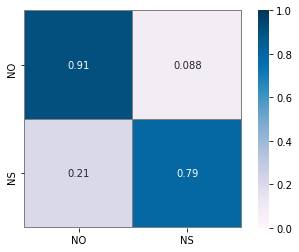

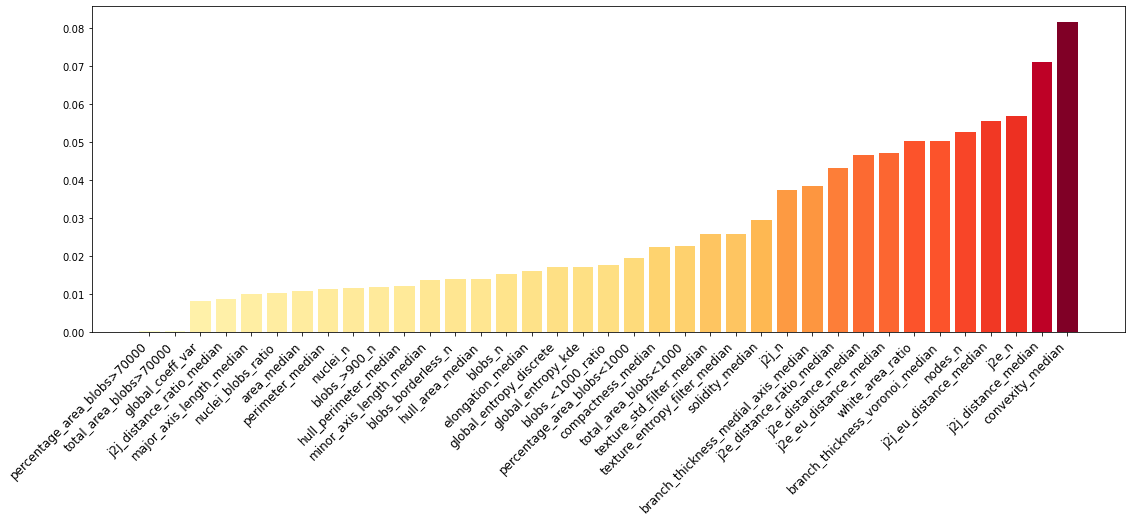

In [22]:
current_data = X_all
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(current_data, y)

predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

plot_ft_importance(clf.feature_importances_, current_data.columns)

              precision    recall  f1-score   support

          NO       0.81      0.88      0.85        34
          NS       0.87      0.79      0.83        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68



(<Figure size 1332x432 with 1 Axes>, <AxesSubplot:>)

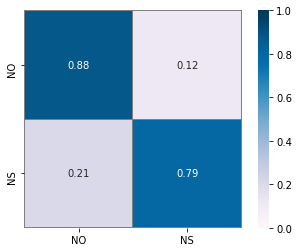

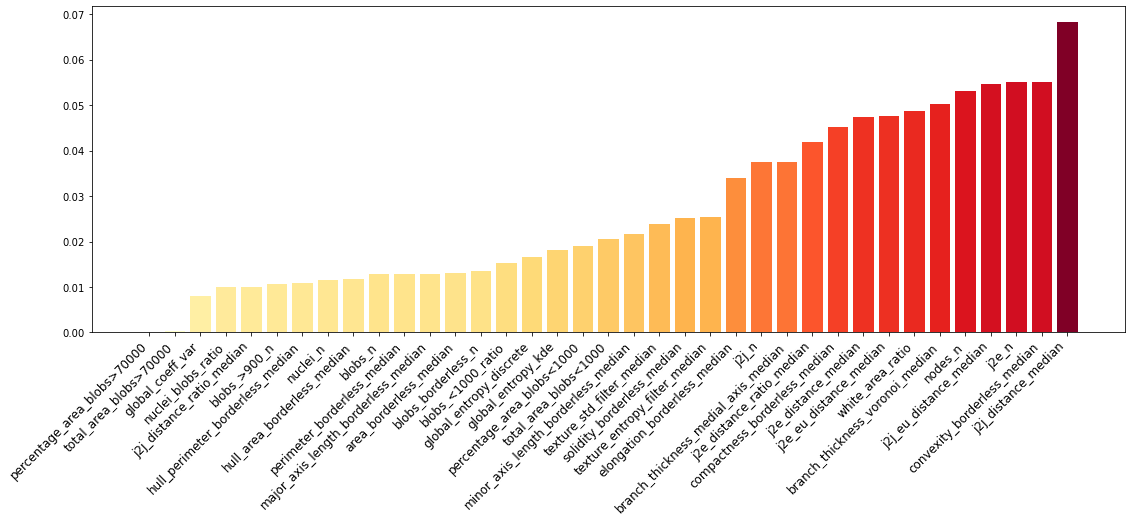

In [23]:
current_data = X_borderless
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(current_data, y)

predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

plot_ft_importance(clf.feature_importances_, current_data.columns)

              precision    recall  f1-score   support

          NO       0.79      0.88      0.83        34
          NS       0.87      0.76      0.81        34

    accuracy                           0.82        68
   macro avg       0.83      0.82      0.82        68
weighted avg       0.83      0.82      0.82        68



(<Figure size 1332x432 with 1 Axes>, <AxesSubplot:>)

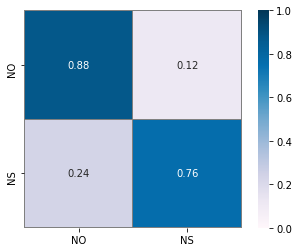

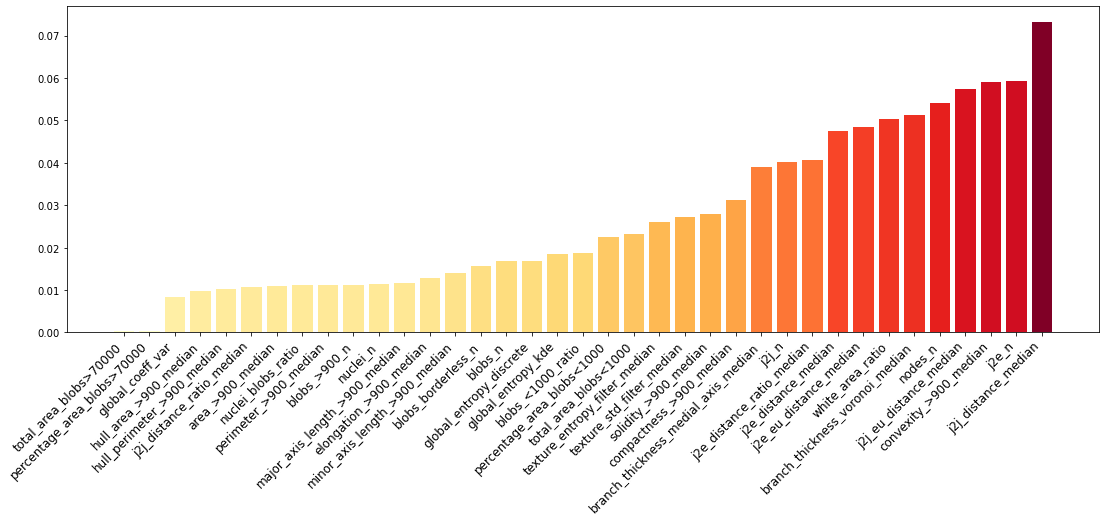

In [24]:
current_data = X_no_small
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(current_data, y)

predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

plot_ft_importance(clf.feature_importances_, current_data.columns)

In [25]:
generator = np.random.default_rng(seed=0)
n_iter = 10
rnd_states = generator.integers(0, 256, n_iter)
n_estimators = generator.integers(1500, 2500, n_iter)
fts_importance_list = []
for idx in range(n_iter):
    print(idx)
    clf = RandomForestClassifier(oob_score=True, max_features="sqrt", 
                                 n_estimators=n_estimators[idx], random_state=rnd_states[idx])
    clf.fit(X_borderless, y)
    predicted_index = clf.oob_decision_function_.argmax(axis=1)
    predicted = np.array(list(clf.classes_[i] for i in predicted_index))
    print(classification_report(y, predicted))
    fts_importance_list.append(clf.feature_importances_)

0
              precision    recall  f1-score   support

          NO       0.81      0.88      0.85        34
          NS       0.87      0.79      0.83        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68

1
              precision    recall  f1-score   support

          NO       0.81      0.88      0.85        34
          NS       0.87      0.79      0.83        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68

2
              precision    recall  f1-score   support

          NO       0.82      0.91      0.86        34
          NS       0.90      0.79      0.84        34

    accuracy                           0.85        68
   macro avg       0.86      0.85      0.85        68
weighted avg       0.86      0.85      0.85        68

3
           

In [26]:
fts_importance_list = np.array(fts_importance_list)
fts_importance_10 = fts_importance_list.mean(axis=0)
fts_importance_10

array([0.01214653, 0.01173361, 0.01229952, 0.01135448, 0.04260189,
       0.02526185, 0.05304127, 0.01165245, 0.02026467, 0.03481953,
       0.05163662, 0.01328498, 0.01227228, 0.00996577, 0.0586531 ,
       0.04212861, 0.04477111, 0.03968063, 0.03617166, 0.06670379,
       0.05581978, 0.00923538, 0.05639665, 0.01120937, 0.01125967,
       0.01507122, 0.01936784, 0.00030343, 0.01912415, 0.00032854,
       0.04259705, 0.05644577, 0.02458756, 0.02486033, 0.01710645,
       0.01809618, 0.00774628])

(<Figure size 1332x432 with 1 Axes>, <AxesSubplot:>)

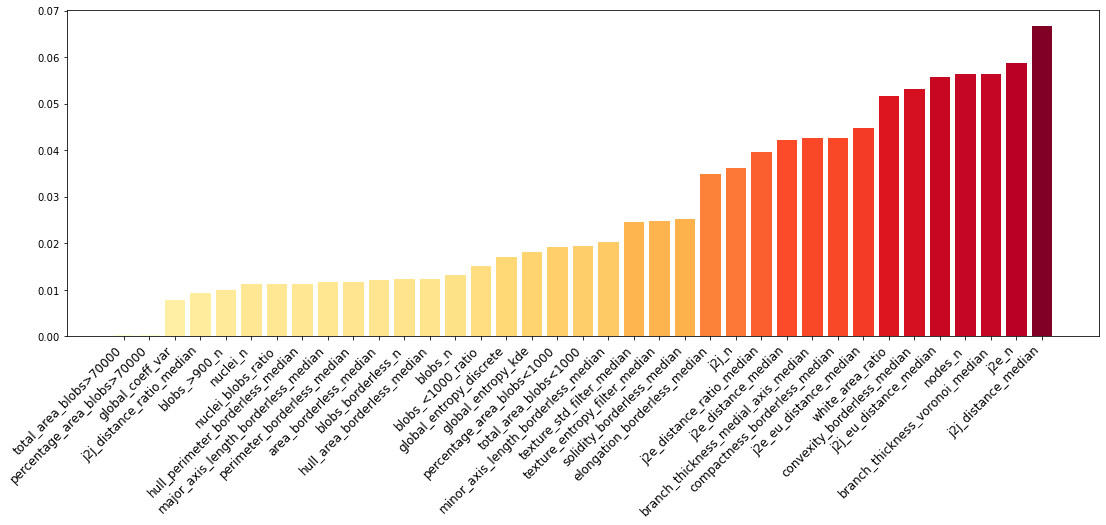

In [27]:
plot_ft_importance(fts_importance_10, X_borderless.columns)

In [28]:
ft_importance_dict = {k: v for k, v in zip(X_borderless.columns, fts_importance_10)}
ft_importance_dict

{'area_borderless_median': 0.012146528152716267,
 'perimeter_borderless_median': 0.011733610650262285,
 'hull_area_borderless_median': 0.012299516925419706,
 'hull_perimeter_borderless_median': 0.011354480299928226,
 'compactness_borderless_median': 0.04260188683646032,
 'solidity_borderless_median': 0.025261847962518756,
 'convexity_borderless_median': 0.053041268149438894,
 'major_axis_length_borderless_median': 0.011652454870405168,
 'minor_axis_length_borderless_median': 0.020264668895285144,
 'elongation_borderless_median': 0.03481953103483128,
 'white_area_ratio': 0.05163662263130399,
 'blobs_n': 0.013284982467463846,
 'blobs_borderless_n': 0.012272283323420705,
 'blobs_>900_n': 0.009965770743533492,
 'j2e_n': 0.0586530973427843,
 'j2e_distance_median': 0.0421286133110481,
 'j2e_eu_distance_median': 0.044771107826581974,
 'j2e_distance_ratio_median': 0.03968063190610067,
 'j2j_n': 0.03617165903548618,
 'j2j_distance_median': 0.06670379497463227,
 'j2j_eu_distance_median': 0.05581

<AxesSubplot:>

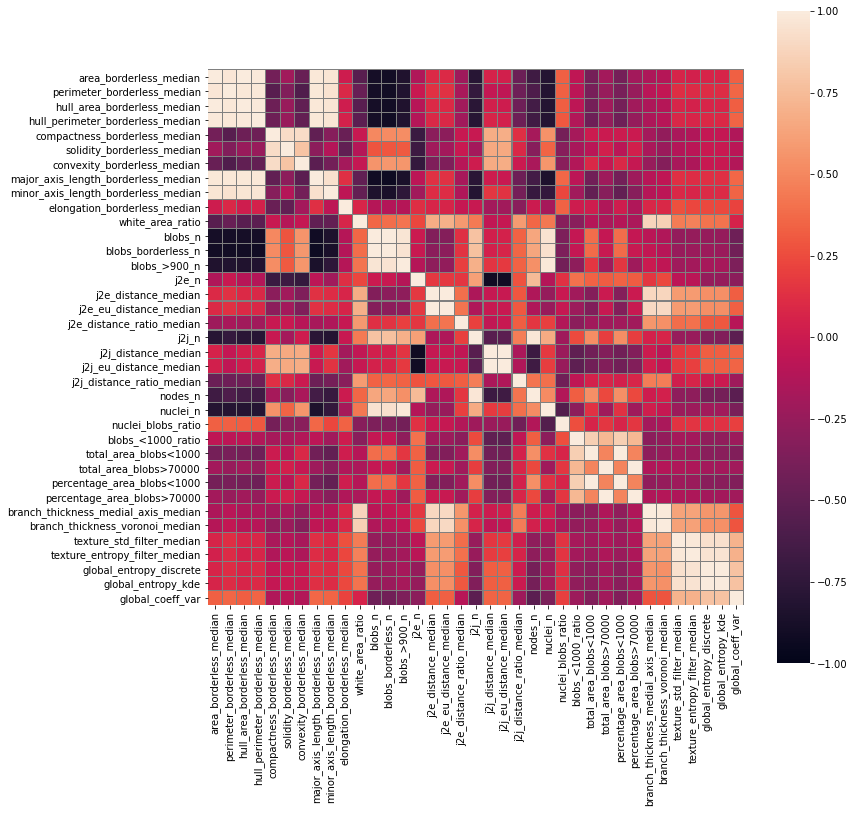

In [29]:
corr = X_borderless.corr()
plt.figure(figsize = (12,12))
sns.heatmap(corr, vmin=-1, vmax=1, square=True, linewidths=0.1, linecolor='gray')

<AxesSubplot:>

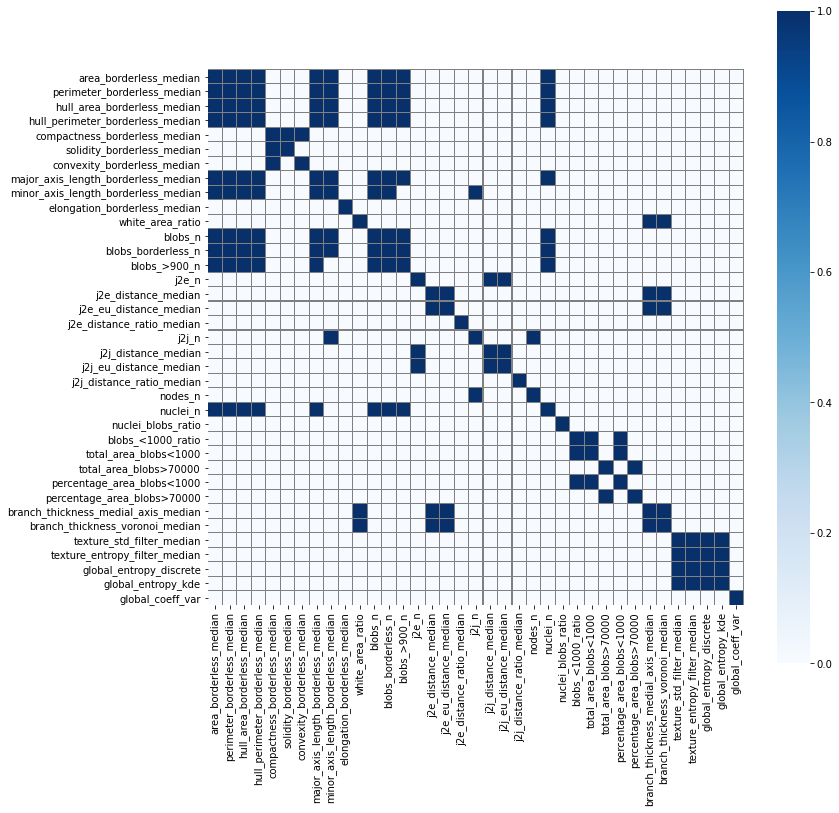

In [30]:
threshold = 0.8
thresh_corr = (abs(corr) > threshold).astype(int)
plt.figure(figsize = (12,12))
sns.heatmap(thresh_corr, vmin=0, vmax=1, square=True, cmap='Blues', linewidths=0.1, linecolor='gray')

In [31]:
def get_uncorrelated_columns(corr_df, theshold, ft_importance_dict): 
    keep = []
    remove = []
    thresh_corr_df = (abs(corr_df) > threshold).astype(int) 
    graph = nx.from_pandas_adjacency(thresh_corr_df)
    connected_components = nx.connected_components(graph)
    for component in connected_components:
        if len(component) == 1:
            keep.append(component.pop())
        else:
            current_ft_imp = {ft: ft_importance_dict[ft] for ft in component}
            max_ft = max(current_ft_imp, key=current_ft_imp.get)
            rest = [ft for ft in component if ft != max_ft]
            keep.append(max_ft)
            remove += rest
    return keep, remove


In [32]:
keep, remove = get_uncorrelated_columns(corr, threshold, ft_importance_dict)
keep, remove

(['nodes_n',
  'convexity_borderless_median',
  'elongation_borderless_median',
  'branch_thickness_voronoi_median',
  'j2j_distance_median',
  'j2e_distance_ratio_median',
  'j2j_distance_ratio_median',
  'nuclei_blobs_ratio',
  'total_area_blobs<1000',
  'percentage_area_blobs>70000',
  'texture_entropy_filter_median',
  'global_coeff_var'],
 ['perimeter_borderless_median',
  'hull_perimeter_borderless_median',
  'major_axis_length_borderless_median',
  'j2j_n',
  'nuclei_n',
  'blobs_borderless_n',
  'blobs_>900_n',
  'area_borderless_median',
  'hull_area_borderless_median',
  'blobs_n',
  'minor_axis_length_borderless_median',
  'solidity_borderless_median',
  'compactness_borderless_median',
  'white_area_ratio',
  'j2e_eu_distance_median',
  'branch_thickness_medial_axis_median',
  'j2e_distance_median',
  'j2j_eu_distance_median',
  'j2e_n',
  'percentage_area_blobs<1000',
  'blobs_<1000_ratio',
  'total_area_blobs>70000',
  'global_entropy_discrete',
  'texture_std_filter_medi

In [33]:
X_borderless_filtered = X_borderless[keep]
X_borderless_filtered

nodes_n  convexity_borderless_median  \
NegsiRNA_E3_NO     2187                     0.927603   
NegsiRNA_L2_NS     1639                     0.925205   
NegsiRNA_H3_NO     1850                     0.937294   
NegsiRNA_G3_NS     1432                     0.944047   
NegsiRNA_B1_NO     1891                     0.951059   
...                 ...                          ...   
NegsiRNA_I2_NO     1894                     0.934052   
NegsiRNA_G3_NO     1943                     0.910640   
NegsiRNA_A1_NO     1275                     0.924468   
NegsiRNA_I3_NO     1813                     0.929273   
NegsiRNA_H3_NS     1564                     0.950238   

                elongation_borderless_median  branch_thickness_voronoi_median  \
NegsiRNA_E3_NO                      1.448576                         8.944272   
NegsiRNA_L2_NS                      1.523195                         6.000000   
NegsiRNA_H3_NO                      1.472948                        10.295630   
NegsiRNA_G3_NS                      1.521927                         7.615773   
NegsiRNA_B1_NO                      1.501067                        10.000000   
...                                      ...                              ...   
NegsiRNA_I2_NO                      1.565276                         8.544003   
NegsiRNA_G3_NO                      1.589326                         9.899495   
NegsiRNA_A1_NO                      1.544299                        11.000000   
NegsiRNA_I3_NO                      1.571240                         8.944272   
NegsiRNA_H3_NS                      1.493704                         8.944272   

                j2j_distance_median  j2e_distance_ratio_median  \
NegsiRNA_E3_NO            40.266715                   0.941882   
NegsiRNA_L2_NS            38.601632                   0.940715   
NegsiRNA_H3_NO            43.120287                   0.946282   
NegsiRNA_G3_NS            55.349168                   0.943207   
NegsiRNA_B1_NO            46.250846                   0.948505   
...                             ...                        ...   
NegsiRNA_I2_NO            44.198083                   0.944422   
NegsiRNA_G3_NO            38.842477                   0.941856   
NegsiRNA_A1_NO            49.259924                   0.946974   
NegsiRNA_I3_NO            42.329852                   0.941784   
NegsiRNA_H3_NS            55.155517                   0.943127   

                j2j_distance_ratio_median  nuclei_blobs_ratio  \
NegsiRNA_E3_NO                   0.931580            1.102564   
NegsiRNA_L2_NS                   0.930580            1.188889   
NegsiRNA_H3_NO                   0.933376            1.049383   
NegsiRNA_G3_NS                   0.929196            1.133858   
NegsiRNA_B1_NO                   0.931275            1.138365   
...                                   ...                 ...   
NegsiRNA_I2_NO                   0.930120            1.114094   
NegsiRNA_G3_NO                   0.932586            1.088889   
NegsiRNA_A1_NO                   0.928598            1.164948   
NegsiRNA_I3_NO                   0.929490            1.121212   
NegsiRNA_H3_NS                   0.931112            1.051948   

                total_area_blobs<1000  percentage_area_blobs>70000  \
NegsiRNA_E3_NO                   5903                          0.0   
NegsiRNA_L2_NS                   2996                          0.0   
NegsiRNA_H3_NO                   2236                          0.0   
NegsiRNA_G3_NS                   1917                          0.0   
NegsiRNA_B1_NO                   2911                          0.0   
...                               ...                          ...   
NegsiRNA_I2_NO                   8161                          0.0   
NegsiRNA_G3_NO                   2760                          0.0   
NegsiRNA_A1_NO                   2740                          0.0   
NegsiRNA_I3_NO                   2425                          0.0   
NegsiRNA_H3_NS            

In [34]:
generator = np.random.default_rng(seed=0)
n_iter = 10
rnd_states = generator.integers(0, 256, n_iter)
n_estimators = generator.integers(1500, 2500, n_iter)
fts_importance_list = []
for idx in range(n_iter):
    print(idx)
    clf = RandomForestClassifier(oob_score=True, max_features="sqrt", 
                                 n_estimators=n_estimators[idx], random_state=rnd_states[idx])
    clf.fit(X_borderless_filtered, y)
    predicted_index = clf.oob_decision_function_.argmax(axis=1)
    predicted = np.array(list(clf.classes_[i] for i in predicted_index))
    print(classification_report(y, predicted))
    fts_importance_list.append(clf.feature_importances_)

0
              precision    recall  f1-score   support

          NO       0.83      0.88      0.86        34
          NS       0.88      0.82      0.85        34

    accuracy                           0.85        68
   macro avg       0.85      0.85      0.85        68
weighted avg       0.85      0.85      0.85        68

1
              precision    recall  f1-score   support

          NO       0.83      0.88      0.86        34
          NS       0.88      0.82      0.85        34

    accuracy                           0.85        68
   macro avg       0.85      0.85      0.85        68
weighted avg       0.85      0.85      0.85        68

2
              precision    recall  f1-score   support

          NO       0.83      0.88      0.86        34
          NS       0.88      0.82      0.85        34

    accuracy                           0.85        68
   macro avg       0.85      0.85      0.85        68
weighted avg       0.85      0.85      0.85        68

3
           

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

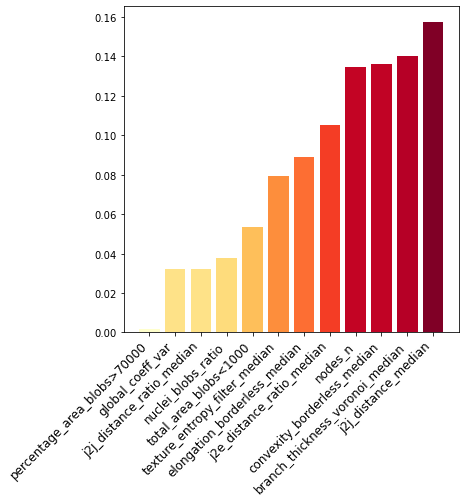

In [35]:
fts_importance_list = np.array(fts_importance_list)
fts_importance_10 = fts_importance_list.mean(axis=0)
plot_ft_importance(fts_importance_10, X_borderless_filtered.columns)

Text(0, 0.5, 'branch_thickness_voronoi_median')

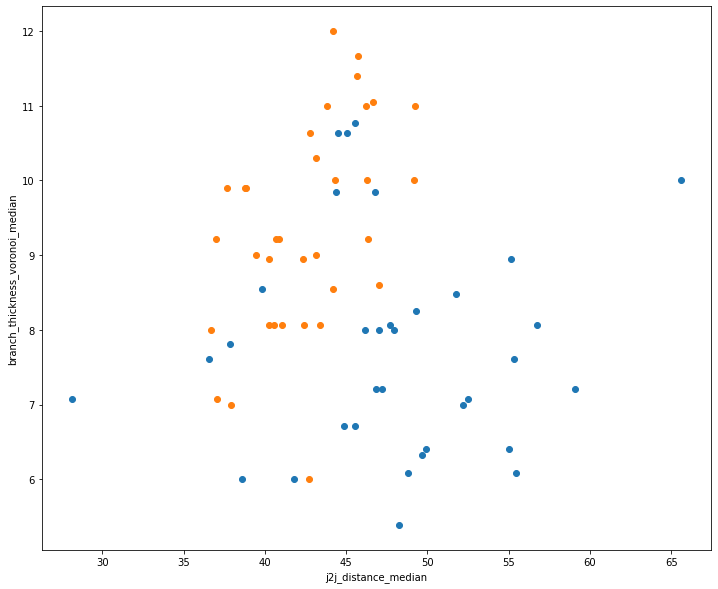

In [36]:
ns_data = X_borderless_filtered[df_negsi['stimulus'] == 'NS']
no_data = X_borderless_filtered[df_negsi['stimulus'] == 'NO']
x_ft = 'j2j_distance_median'
y_ft = 'branch_thickness_voronoi_median'
plt.figure(figsize=(12, 10))
plt.scatter(ns_data[x_ft], ns_data[y_ft])
plt.scatter(no_data[x_ft], no_data[y_ft])
plt.xlabel(x_ft)
plt.ylabel(y_ft)

In [37]:
def get_pca_df(df):
    n_components = len(df.columns) - 1
    columns = [f'pc_{iii}' for iii in range(1, n_components+1)]
    pipe = Pipeline([('scaler', MinMaxScaler()), ('pca', PCA(n_components=n_components))]) # normalization and PCA
    df_pca_values = pipe.fit_transform(df)
    df_pca = pd.DataFrame(data=df_pca_values, index=df.index, columns=columns)
    return df_pca, pipe

In [46]:
df_pca, pipe_pca = get_pca_df(X_borderless_filtered)
df_pca

pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
NegsiRNA_E3_NO  0.138256 -0.327057 -0.063215 -0.251497  0.187866 -0.000277   
NegsiRNA_L2_NS  0.463397  0.079410 -0.285507 -0.309894 -0.115564  0.019105   
NegsiRNA_H3_NO -0.562170 -0.231161  0.301559 -0.086598  0.242961  0.006119   
NegsiRNA_G3_NS  0.117862  0.461035  0.155407 -0.111271 -0.130135 -0.046631   
NegsiRNA_B1_NO -0.223187 -0.210443  0.210267  0.102578 -0.271105 -0.189202   
...                  ...       ...       ...       ...       ...       ...   
NegsiRNA_I2_NO -0.222702  0.175260 -0.171407  0.235324  0.164274 -0.120320   
NegsiRNA_G3_NO -0.244807 -0.239541 -0.300267 -0.166822  0.104091  0.385595   
NegsiRNA_A1_NO -0.602710  0.440349 -0.104897 -0.041756 -0.162385 -0.261012   
NegsiRNA_I3_NO -0.035258  0.219760 -0.227006 -0.073609 -0.031435  0.147186   
NegsiRNA_H3_NS -0.047451  0.135338  0.354473  0.072479  0.238160 -0.005744   

                    pc_7      pc_8      pc_9     pc_10     pc_11  
NegsiRNA_E3_NO -0.013743 -0.034079  0.190718 -0.020617  0.020219  
NegsiRNA_L2_NS  0.284953  0.018939 -0.082300 -0.062970  0.136862  
NegsiRNA_H3_NO  0.062409 -0.206122 -0.050306  0.098384 -0.032132  
NegsiRNA_G3_NS  0.013844  0.067567  0.013596  0.009306 -0.079377  
NegsiRNA_B1_NO  0.122584  0.097232  0.121247  0.034137 -0.027040  
...                  ...       ...       ...       ...       ...  
NegsiRNA_I2_NO -0.138396 -0.165775 -0.036819 -0.016484  0.048007  
NegsiRNA_G3_NO  0.123582  0.027504 -0.076071 -0.019239  0.111056  
NegsiRNA_A1_NO -0.153977  0.233090  0.002235 -0.049266  0.010646  
NegsiRNA_I3_NO -0.053932  0.056322  0.103184  0.080971  0.089786  
NegsiRNA_H3_NS -0.131422  0.024304 -0.057786 -0.105255 -0.084467  

[68 rows x 11 columns]

Text(0, 0.5, 'pc_2')

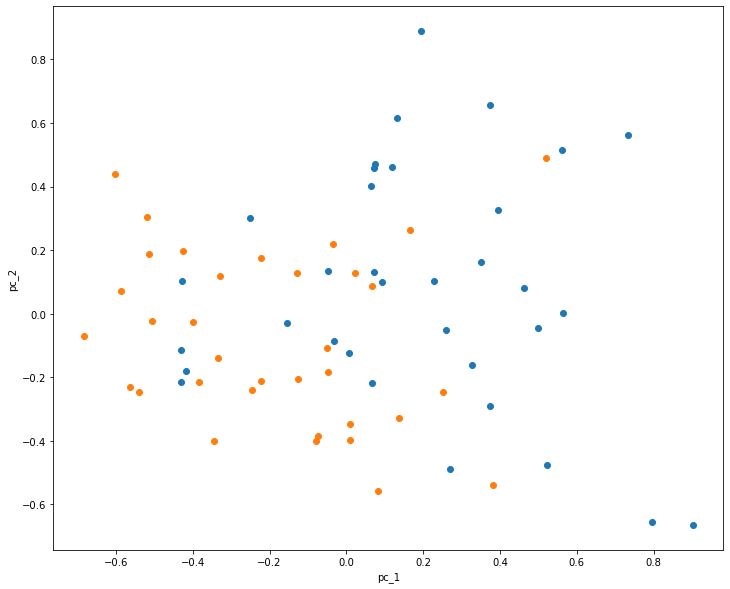

In [47]:
ns_data = df_pca[df_negsi['stimulus'] == 'NS']
no_data = df_pca[df_negsi['stimulus'] == 'NO']
x_ft = 'pc_1'
y_ft = 'pc_2'
plt.figure(figsize=(12, 10))
plt.scatter(ns_data[x_ft], ns_data[y_ft])
plt.scatter(no_data[x_ft], no_data[y_ft])
plt.xlabel(x_ft)
plt.ylabel(y_ft)

In [48]:
df_pca_2ft = df_pca[['pc_1', 'pc_2']]
clf = Pipeline([('model', SVC(kernel='linear', C=100))])
#param_grid = [
 # {'model__C': np.arange(0.1, 1000, 10)},
#]

#clf = GridSearchCV(pipe, param_grid, n_jobs=-1)
#print("Best parameter (CV score=%0.3f):" % clf.best_score_)
#print(clf.best_params_)
scores = cross_val_score(clf, df_pca_2ft, y, cv=10)
scores.mean(), scores.std()

(0.75, 0.09236745114890868)

In [49]:
clf.fit(df_pca_2ft, y)
y_pred = clf.predict(df_pca_2ft)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          NO       0.73      0.79      0.76        34
          NS       0.77      0.71      0.74        34

    accuracy                           0.75        68
   macro avg       0.75      0.75      0.75        68
weighted avg       0.75      0.75      0.75        68



In [74]:
def plot_boundaries(X, y, clf, x_coord, y_coord, n_points=100, plot_lines=True, add_text=False):
    colors = {'NS': 'tab:red', 'NO': 'tab:blue'}
    colors_others = {'NS': 'magenta', 'NO': 'tab:cyan'}
    model = clf['model']
    padding = 0.01
    

    #min_x = X[x_coord].min() - padding
    #max_x = X[x_coord].max() + padding
    #min_y = X[y_coord].min() - padding
    #max_y = X[y_coord].max() + padding
    
    min_x = -1 - padding
    max_x = 2 + padding
    min_y = -1 - padding
    max_y = 1 + padding

    #min_x = min_y = 0
    #max_x = max_y = 5
    xx, yy = np.meshgrid(np.linspace(min_x, max_x, n_points), np.linspace(min_y, max_y, n_points))

    predictions = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    fig, axes = plt.subplots(1, figsize=(15, 10))

    axes.contourf(xx, yy, np.sign(predictions), cmap=plt.cm.coolwarm, alpha=0.5)
    # axes.contour(xx, yy, predictions, colors='k', levels=[-1, 0, 1], alpha=0.8, linestyles=['--', '-', '--'])

    for label in ['NO', 'NS']:
        current_X = X[y == label]
        axes.scatter(current_X[x_coord], current_X[y_coord], label=label, color=colors[label])

    if add_text:
        for index, row in X.iterrows():
            x0, y0 = row[x_coord], row[y_coord]
            axes.text(x0 + padding / 10, y0 + padding / 10, index)

    if plot_lines:
        name_and_plate = set("_".join(name.split("_")[:-1]) for name in X.index)

        for nap in name_and_plate:
            x0, y0 = X.loc[f'{nap}_NS', x_coord], X.loc[f'{nap}_NS', y_coord]
            x1, y1 = X.loc[f'{nap}_NO', x_coord], X.loc[f'{nap}_NO', y_coord]
            axes.plot((x0, x1), (y0, y1), c='gray')
            axes.plot((x0, x1), (y0, y1), c='gray')

    axes.set_xlabel(x_coord)
    axes.set_ylabel(y_coord)
    axes.set_xlim((min_x, max_x))
    axes.set_ylim((min_y, max_y))
    axes.legend()

    return fig, axes

(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:xlabel='pc_1', ylabel='pc_2'>)

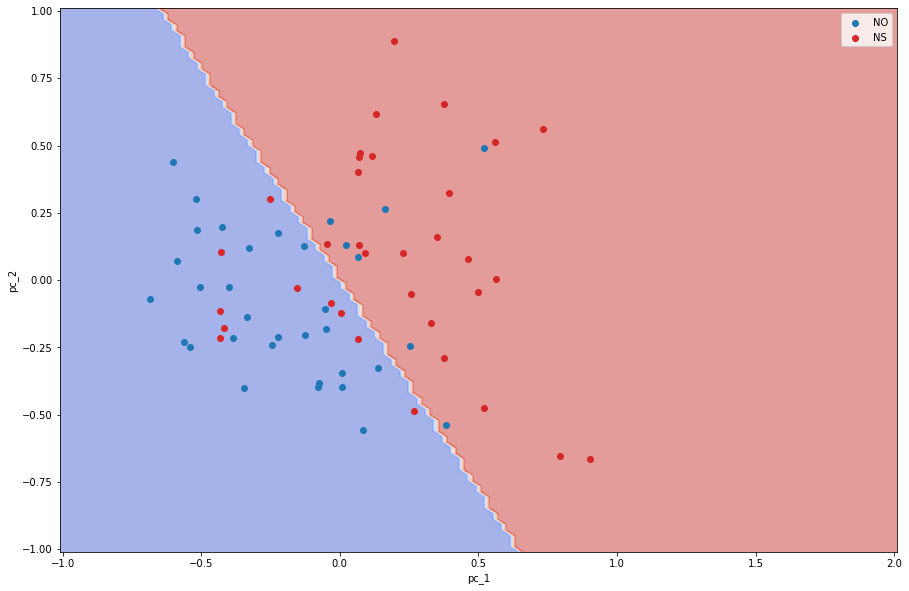

In [75]:
plot_boundaries(df_pca_2ft, y, clf, 'pc_1', 'pc_2', plot_lines=False)

In [64]:
df_rest = df[(df['protein'] != 'NegsiRNA') & (df['stimulus'] != 'CA')]
df_rest

protein plate stimulus  white_area_ratio      area_mean  \
AKT1_B2_NO      AKT1    B2       NO          0.330304    9813.732919   
ACTN1_B2_NS    ACTN1    B2       NS          0.129066   14470.070423   
JUP_D1_NO        JUP    D1       NO          0.291828    6875.662551   
CTNNB1_A1_NS  CTNNB1    A1       NS          0.221042   14820.887097   
FYN_E3_NS        FYN    E3       NS          0.252473   11233.356688   
...              ...   ...      ...               ...            ...   
CTNNA1_A1_NS  CTNNA1    A1       NS          0.112984   28280.108108   
DNMBP_A3_NO    DNMBP    A3       NO          0.226212   11854.506494   
CDH1_B1_NS      CDH1    B1       NS          0.008041  780108.333333   
CTNNA1_A3_NO  CTNNA1    A3       NO          0.153547   11816.662722   
ENAH_B3_NO      ENAH    B3       NO          0.261689   10010.890805   

                  area_std  area_median  area_mad  area_mode  perimeter_mean  \
AKT1_B2_NO    6.168496e+03       9421.0    3578.0        630      439.762406   
ACTN1_B2_NS   1.163439e+04      13463.5    8544.0        103      554.889710   
JUP_D1_NO     4.192131e+03       6626.0    3009.0       4465      357.621712   
CTNNB1_A1_NS  1.137919e+04      12763.0    8194.0        156      541.275670   
FYN_E3_NS     6.133822e+03      10890.0    3665.0      17118      456.227522   
...                    ...          ...       ...        ...             ...   
CTNNA1_A1_NS  1.122986e+05       1968.5    1929.5          7      755.610417   
DNMBP_A3_NO   9.443554e+03      10429.0    6573.5      16540      495.713790   
CDH1_B1_NS    1.348136e+06       3070.0    2616.0        454     4935.412540   
CTNNA1_A3_NO  1.524681e+04       8115.0    7508.0        178      480.798606   
ENAH_B3_NO    7.062259e+03       8996.0    4996.0         45      440.324334   

              ...  texture_std_filter_mad  texture_std_filter_mode  \
AKT1_B2_NO    ...              694.106445              1188.369629   
ACTN1_B2_NS   ...              195.372681               328.295410   
JUP_D1_NO     ...              266.486145               453.509460   
CTNNB1_A1_NS  ...              666.926758               968.437134   
FYN_E3_NS     ...              407.968201               685.691772   
...           ...                     ...                      ...   
CTNNA1_A1_NS  ...              541.477783               786.701843   
DNMBP_A3_NO   ...              361.706299               848.246582   
CDH1_B1_NS    ...              206.110138               409.006592   
CTNNA1_A3_NO  ...              279.118835               525.445984   
ENAH_B3_NO    ...              582.517944              1232.572144   

              texture_entropy_filter_mean  texture_entropy_filter_std  \
AKT1_B2_NO                       4.154108                    0.523035   
ACTN1_B2_NS                      2.868770                    0.649364   
JUP_D1_NO                        3.290104                    0.592684   
CTNNB1_A1_NS                     4.047129                    0.570934   
FYN_E3_NS                        3.663046                    0.595786   
...                                   ...                         ...   
CTNNA1_A1_NS                     3.878884                    0.574353   
DNMBP_A3_NO                      3.642820                    0.560697   
CDH1_B1_NS                       3.097695                    0.600949   
CTNNA1_A3_NO                     3.328485                    0.597775   
ENAH_B3_NO                       4.054212                    0.530159   

              texture_entropy_filter_median  texture_entropy_filter_mad  \
AKT1_B2_NO                         4.191269                    0.372221   
ACTN1_B2_NS                        2.851499                    0.478579   
JUP_D1_NO                          3.279088                    0.426149   
CTNNB1_A1_NS                       4.090811                    0.404744   
FYN_E3_NS                          3.660657                    0.425607   
...                

In [65]:
X_rest = df_rest[X_borderless_filtered.columns]
y_rest = df_rest['stimulus']
X_rest

nodes_n  convexity_borderless_median  \
AKT1_B2_NO       1585                     0.938025   
ACTN1_B2_NS      1416                     0.924240   
JUP_D1_NO        1888                     0.961744   
CTNNB1_A1_NS     1244                     0.937370   
FYN_E3_NS        1343                     0.956283   
...               ...                          ...   
CTNNA1_A1_NS     1145                     0.990028   
DNMBP_A3_NO      1867                     0.913420   
CDH1_B1_NS        131                     0.955580   
CTNNA1_A3_NO     1903                     0.951312   
ENAH_B3_NO       1703                     0.941012   

              elongation_borderless_median  branch_thickness_voronoi_median  \
AKT1_B2_NO                        1.481216                        10.295630   
ACTN1_B2_NS                       1.597083                         2.236068   
JUP_D1_NO                         1.526889                         7.211102   
CTNNB1_A1_NS                      1.723823                         7.615773   
FYN_E3_NS                         1.484431                         7.810250   
...                                    ...                              ...   
CTNNA1_A1_NS                      2.113730                         4.242640   
DNMBP_A3_NO                       1.558548                         6.403124   
CDH1_B1_NS                        1.740286                         2.236068   
CTNNA1_A3_NO                      1.758946                         4.123106   
ENAH_B3_NO                        1.576126                         7.615773   

              j2j_distance_median  j2e_distance_ratio_median  \
AKT1_B2_NO              48.069156                   0.946151   
ACTN1_B2_NS             50.655844                   0.932379   
JUP_D1_NO               50.074665                   0.941861   
CTNNB1_A1_NS            30.810270                   0.932708   
FYN_E3_NS               62.930409                   0.945683   
...                           ...                        ...   
CTNNA1_A1_NS            44.970068                   0.933116   
DNMBP_A3_NO             38.475662                   0.943330   
CDH1_B1_NS              35.191967                   0.928564   
CTNNA1_A3_NO            31.620231                   0.935070   
ENAH_B3_NO              44.685800                   0.938893   

              j2j_distance_ratio_median  nuclei_blobs_ratio  \
AKT1_B2_NO                     0.931202            1.254098   
ACTN1_B2_NS                    0.924009            1.078947   
JUP_D1_NO                      0.930687            1.121359   
CTNNB1_A1_NS                   0.935206            1.217391   
FYN_E3_NS                      0.929178            1.056738   
...                                 ...                 ...   
CTNNA1_A1_NS                   0.933588            0.641791   
DNMBP_A3_NO                    0.928304            1.301887   
CDH1_B1_NS                     0.926038            0.016529   
CTNNA1_A3_NO                   0.934236            0.984375   
ENAH_B3_NO                     0.928526            1.115108   

              total_area_blobs<1000  percentage_area_blobs>70000  \
AKT1_B2_NO                     5147                     0.000000   
ACTN1_B2_NS                    4237                     0.000000   
JUP_D1_NO                      7078                     0.000000   
CTNNB1_A1_NS                   5815                     0.000000   
FYN_E3_NS                      4345                     0.000000   
...                             ...                          ...   
CTNNA1_A1_NS                   5601                     0.645382   
DNMBP_A3_NO                    7408                     0.000000   
CDH1_B1_NS                      454                     0.990465   
CTNNA1_A3_NO                  14172                     0.112158   
ENAH_B3_NO                    10601                     0.000000   

              texture_entropy_filter_median  global_coeff_var  
AKT1_B2_N

In [66]:
X_rest_ns = X_rest[y_rest == 'NS']
y_rest_ns = y_rest[y_rest == 'NS']
X_rest_ns

nodes_n  convexity_borderless_median  \
ACTN1_B2_NS      1416                     0.924240   
CTNNB1_A1_NS     1244                     0.937370   
FYN_E3_NS        1343                     0.956283   
GNA12_E1_NS      1213                     0.961376   
ACTB_B2_NS       1796                     0.939078   
...               ...                          ...   
P2RX4_E1_NS      1314                     0.943605   
ACTN4_L1_NS      1986                     0.953061   
MYO7A_D3_NS      1567                     0.941394   
CTNNA1_A1_NS     1145                     0.990028   
CDH1_B1_NS        131                     0.955580   

              elongation_borderless_median  branch_thickness_voronoi_median  \
ACTN1_B2_NS                       1.597083                         2.236068   
CTNNB1_A1_NS                      1.723823                         7.615773   
FYN_E3_NS                         1.484431                         7.810250   
GNA12_E1_NS                       1.531764                         8.544003   
ACTB_B2_NS                        1.463977                        13.341664   
...                                    ...                              ...   
P2RX4_E1_NS                       1.536657                         7.810250   
ACTN4_L1_NS                       1.509861                         7.000000   
MYO7A_D3_NS                       1.484673                         7.810250   
CTNNA1_A1_NS                      2.113730                         4.242640   
CDH1_B1_NS                        1.740286                         2.236068   

              j2j_distance_median  j2e_distance_ratio_median  \
ACTN1_B2_NS             50.655844                   0.932379   
CTNNB1_A1_NS            30.810270                   0.932708   
FYN_E3_NS               62.930409                   0.945683   
GNA12_E1_NS             62.894531                   0.939563   
ACTB_B2_NS              46.246636                   0.941784   
...                           ...                        ...   
P2RX4_E1_NS             53.668524                   0.941170   
ACTN4_L1_NS             49.048343                   0.939954   
MYO7A_D3_NS             48.956333                   0.945968   
CTNNA1_A1_NS            44.970068                   0.933116   
CDH1_B1_NS              35.191967                   0.928564   

              j2j_distance_ratio_median  nuclei_blobs_ratio  \
ACTN1_B2_NS                    0.924009            1.078947   
CTNNB1_A1_NS                   0.935206            1.217391   
FYN_E3_NS                      0.929178            1.056738   
GNA12_E1_NS                    0.928268            1.091603   
ACTB_B2_NS                     0.933023            1.109489   
...                                 ...                 ...   
P2RX4_E1_NS                    0.927841            1.213592   
ACTN4_L1_NS                    0.930261            1.059406   
MYO7A_D3_NS                    0.928759            1.070922   
CTNNA1_A1_NS                   0.933588            0.641791   
CDH1_B1_NS                     0.926038            0.016529   

              total_area_blobs<1000  percentage_area_blobs>70000  \
ACTN1_B2_NS                    4237                     0.000000   
CTNNB1_A1_NS                   5815                     0.000000   
FYN_E3_NS                      4345                     0.000000   
GNA12_E1_NS                    2557                     0.000000   
ACTB_B2_NS                     6767                     0.000000   
...                             ...                          ...   
P2RX4_E1_NS                    9801                     0.000000   
ACTN4_L1_NS                    7699                     0.000000   
MYO7A_D3_NS                    1780                     0.000000   
CTNNA1_A1_NS                   5601                     0.645382   
CDH1_B1_NS                      454                     0.990465   

              texture_entropy_filter_median  global_coeff_var  
ACTN1_B2_

In [69]:
n_components = len(X_rest_ns.columns) - 1
columns = [f'pc_{iii}' for iii in range(1, n_components+1)]
pca_values = pipe_pca.transform(X_rest_ns)
df_pca_rest_ns = pd.DataFrame(data=pca_values, index=X_rest_ns.index, columns=columns)

(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:xlabel='pc_1', ylabel='pc_2'>)

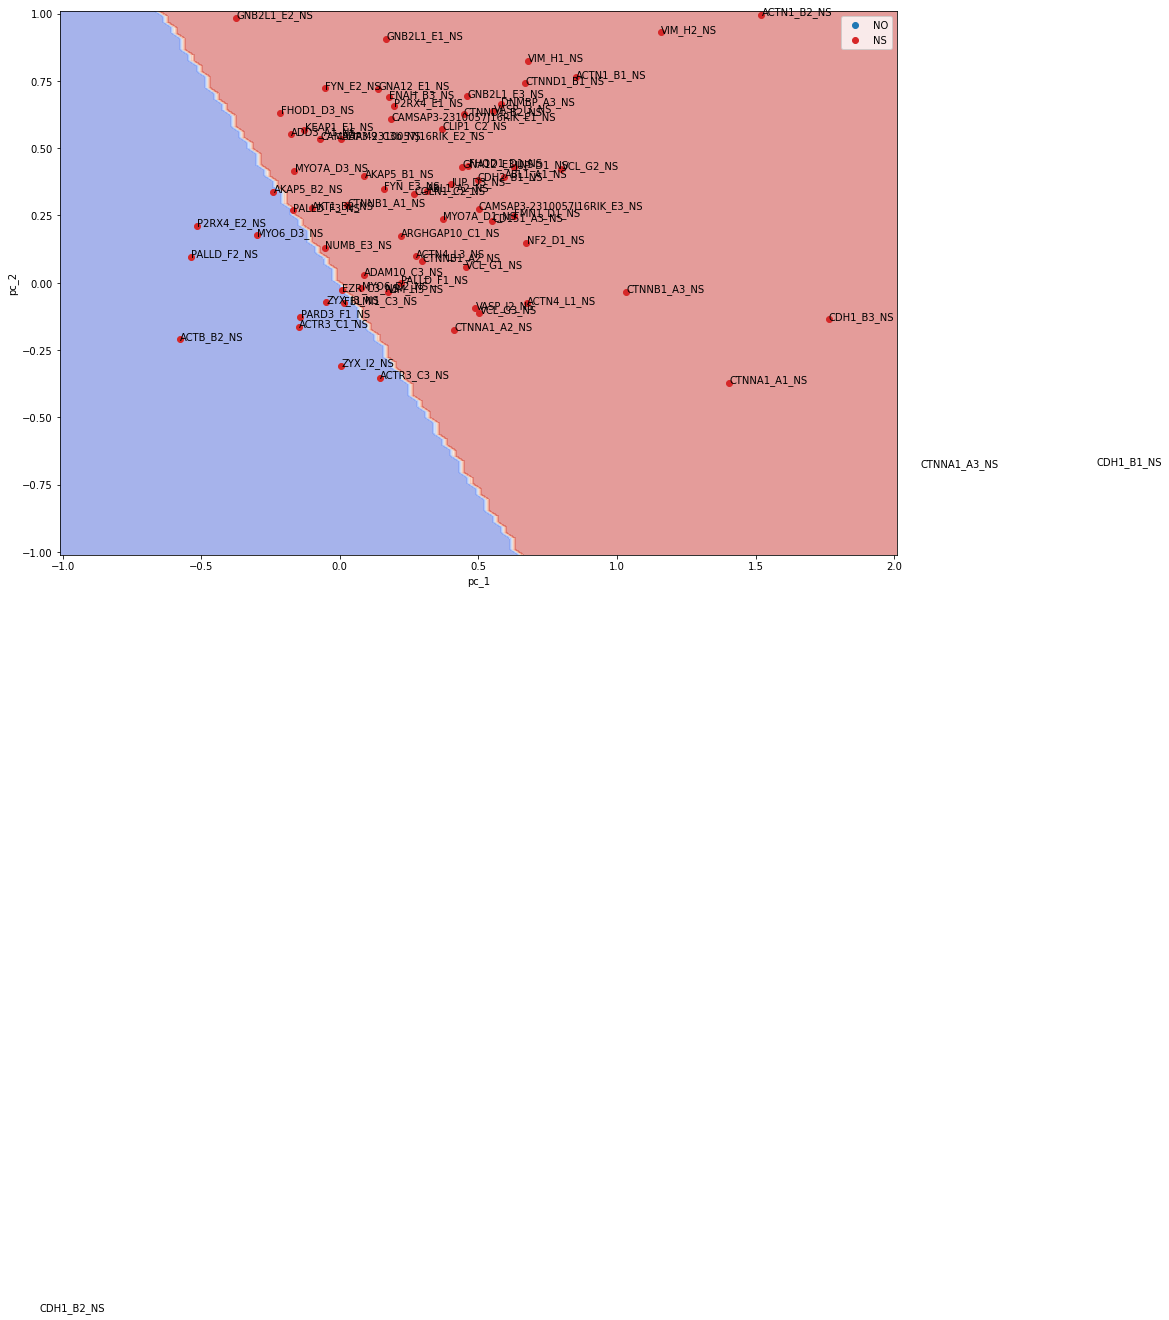

In [77]:
plot_boundaries(df_pca_rest_ns, y_rest_ns, clf, 'pc_1', 'pc_2', plot_lines=False, add_text=True)

In [205]:
df_blobs_paths = glob.glob(os.path.join('../data/interim/dataframes/blobs_data', 'NegsiRNA*.csv'))
dfs = {path.split("/")[-1].split(".")[0]: pd.read_csv(path, index_col=0) for path in df_blobs_paths}

In [236]:
upper_thresh = 40000
lower_thresh = 900
n_blobs_dict = {}
for name, df in dfs.items():
    df_filtered = df[~(df['is_at_border']) & (df['area'] > lower_thresh) & (df['area'] < upper_thresh)]
    n_blobs_dict[name] = len(df_filtered)

In [237]:
df_n_blobs = pd.DataFrame.from_dict(n_blobs_dict, orient='index', columns=['n_blobs'])
df_n_blobs = df_n_blobs[df_n_blobs.index.str.split("_").str[2] != 'CA'].sort_values(by='n_blobs')
df_n_blobs

n_blobs
NegsiRNA_E1_NS        48
NegsiRNA_C3c_NS       57
NegsiRNA_L3_NS        63
NegsiRNA_L2_NS        64
NegsiRNA_A1_NO        77
NegsiRNA_L2_NO        78
NegsiRNA_A1_NS        78
NegsiRNA_A1b_NO       81
NegsiRNA_L3_NO        84
NegsiRNA_F2_NS        86
NegsiRNA_A2b_NO       87
NegsiRNA_F3_NS        88
NegsiRNA_E1_NO        88
NegsiRNA_D3_NS        88
NegsiRNA_C3c_NO       91
NegsiRNA_D3_NO        93
NegsiRNA_F2_NO        93
NegsiRNA_A1b_NS       95
NegsiRNA_E2_NS        96
NegsiRNA_A3_NO        96
NegsiRNA_B2_NS        97
NegsiRNA_B2_NO        98
NegsiRNA_F3_NO        99
NegsiRNA_G2_NS       101
NegsiRNA_E2_NO       102
NegsiRNA_G3_NS       104
NegsiRNA_I3_NS       105
NegsiRNA_G3_NO       106
NegsiRNA_I3_NO       106
NegsiRNA_A2_NO       110
NegsiRNA_I1_NO       112
NegsiRNA_C2_NO       115
NegsiRNA_A2_NS       116
NegsiRNA_C3b_NS      118
NegsiRNA_E3_NS       119
NegsiRNA_H3_NS       121
NegsiRNA_C3_NS       121
NegsiRNA_A2b_NS      121
NegsiRNA_I2_NS       123
NegsiRNA_G2_NO       123
NegsiRNA_H3_NO       125
NegsiRNA_C2_NS       127
NegsiRNA_I2_NO       128
NegsiRNA_H2_NS       129
NegsiRNA_A3_NS       131
NegsiRNA_H1_NO       133
NegsiRNA_E3_NO       134
NegsiRNA_D2_NO       135
NegsiRNA_D2_NS       137
NegsiRNA_H2_NO       138
NegsiRNA_B1_NO       143
NegsiRNA_D1_NO       144
NegsiRNA_C1_NO       144
NegsiRNA_B1_NS       145
NegsiRNA_C1_NS       145
NegsiRNA_C3_NO       145
NegsiRNA_D1_NS       148
NegsiRNA_H1_NS       149
NegsiRNA_B3_NO       151
NegsiRNA_C3b_NO      151
NegsiRNA_I1_NS       156
NegsiRNA_B3_NS       157
NegsiRNA_F1_NS       157
NegsiRNA_G1_NO       158
NegsiRNA_F1_NO       168
NegsiRNA_G1_NS       182
NegsiRNA_L1_NO       184
NegsiRNA_L1_NS       221

In [233]:
X_borderless_filtered.loc[df_n_blobs.index]

NegsiRNA_E3_NS                          6.324555                 4.902409   
NegsiRNA_E3_NO                          8.944272                 5.042615   
NegsiRNA_H1_NS                          8.000000                 5.237782   
NegsiRNA_H1_NO                         11.000000                 5.245799   
NegsiRNA_B1_NO                         10.000000                 5.269819   
NegsiRNA_L2_NO                          8.000000                 5.293038   
NegsiRNA_D1_NS                          6.708204                 5.108597   

                 j2e_distance_ratio_median  j2e_distance_ratio_entropy  \
NegsiRNA_H2_NS                    0.946163                   -2.538945   
NegsiRNA_A1b_NS                   0.938478                   -2.647304   
NegsiRNA_G3_NO                    0.941856                   -2.805585   
NegsiRNA_H2_NO                    0.943089                   -2.594054   
NegsiRNA_L2_NS                    0.940715                   -2.671102   
NegsiRNA_F2_NS                    0.945821                   -2.838887   
NegsiRNA_G2_NS                    0.947488                   -2.736165   
NegsiRNA_L1_NO                    0.942788                   -2.884541   
NegsiRNA_G1_NS                    0.946216                   -2.838967   
NegsiRNA_E1_NO                    0.947916                   -2.502963   
NegsiRNA_F2_NO                    0.947659                   -2.655631   
NegsiRNA_L3_NS                    0.939683                   -2.743578   
NegsiRNA_G3_NS                    0.943207                   -2.893772   
NegsiRNA_I3_NO                    0.941784                   -2.912259   
NegsiRNA_I2_NO                    0.944422                   -2.900120   
NegsiRNA_A2_NO                    0.946163                   -2.842234   
NegsiRNA_C1_NO                    0.946543                   -2.795875   
NegsiRNA_D1_NO                    0.947673                   -2.784449   
NegsiRNA_C3_NO                    0.946282                   -2.821488   
NegsiRNA_D2_NS                    0.944212                   -2.780516   
NegsiRNA_L1_NS                    0.944103                   -2.717291   
NegsiRNA_A3_NS                    0.941784                   -2.572352   
NegsiRNA_B3_NS                    0.936741                   -2.593717   
NegsiRNA_A1b_NO                   0.945209                   -2.502069   
NegsiRNA_C1_NS                    0.944382                   -2.616955   
NegsiRNA_A2b_NO                   0.944157                   -2.959881   
NegsiRNA_C3c_NS                   0.939713                   -2.484994   
NegsiRNA_A2_NS                    0.941784                   -2.884074   
NegsiRNA_H3_NO                    0.946282                   -2.834516   
NegsiRNA_A1_NS                    0.939556                   -2.850290   
NegsiRNA_D2_NO                    0.944802                   -2.872650   
NegsiRNA_E1_NS                    0.939820                   -2.585990   
NegsiRNA_B1_NS                    0.939954                   -2.657966   
NegsiRNA_B2_NS                    0.946523                   -2.793590   
NegsiRNA_L3_NO                    0.945209                   -2.735216   
NegsiRNA_B2_NO                    0.943844                   -2.981728   
NegsiRNA_C2_NO                    0.945857                   -2.858490   
NegsiRNA_E2_NS                    0.943345                   -2.680443   
NegsiRNA_I1_NO                    0.947115                   -2.919933   
NegsiRNA_I1_NS                    0.944103                   -2.956568   
NegsiRNA_G1_NO                    0.946567                   -2.754938   
NegsiRNA_C3_NS                    0.942572                   -2.797975   
NegsiRNA_A1_NO                    0.946974                   -2.955289   
NegsiRNA_F1_NO                    0.946842                   -2.846113   
NegsiRNA_C3b_NS                   0.946216                   -3.090235   
NegsiRNA_F1_NS                    0.942248              

In [242]:
nuclei_img, ccj_img, seg_img, _ = utils.load_images('../data/raw/images', 'NegsiRNA_E1_NS')
df_blobs, label_img = blobsutils.get_blobs_measurements(seg_img, return_img=True)

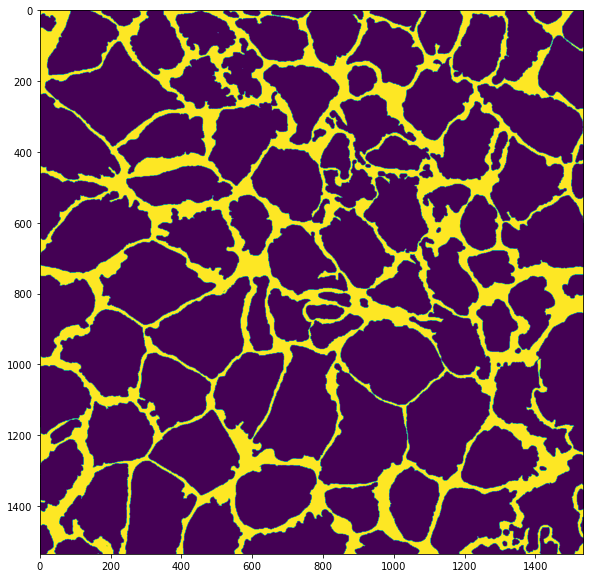

In [262]:
plt.figure(figsize=(10, 10))
plt.imshow(seg_img)

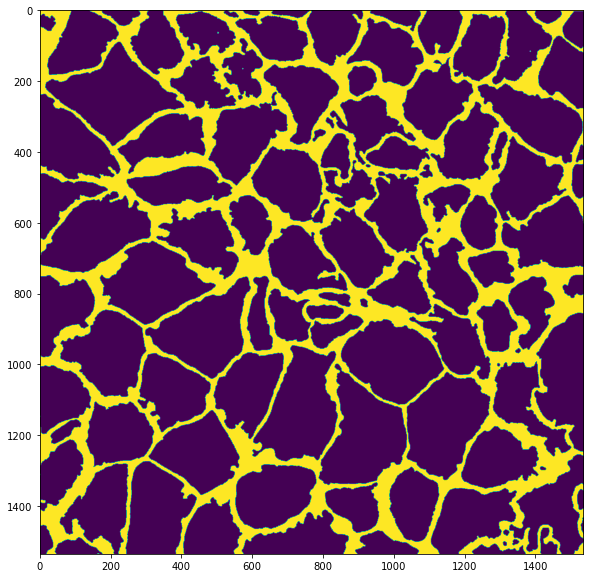

In [265]:
seg_img_dilated = dilation(seg_img, square(3))
plt.figure(figsize=(10, 10))
plt.imshow(seg_img_dilated)

In [266]:
df_blobs_dilated, label_img_dilated = blobsutils.get_blobs_measurements(seg_img_dilated, return_img=True)

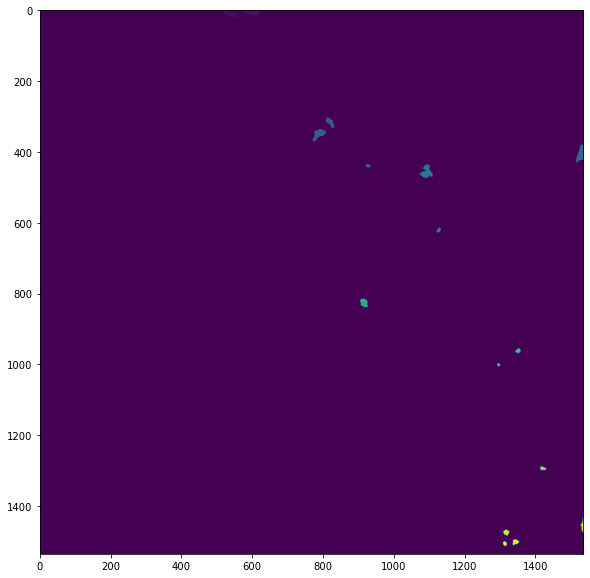

In [274]:
upper_thresh = 70000
lower_thresh = 1000
discarded_blobs = (df_blobs_dilated['area'] > upper_thresh) | (df_blobs_dilated['area'] < lower_thresh)
plt.figure(figsize=(10, 10))
masked_img = label_img_dilated
masked_img[~np.isin(label_img_dilated, df_blobs_dilated.loc[discarded_blobs, 'label'].values)] = 0
plt.imshow(masked_img)

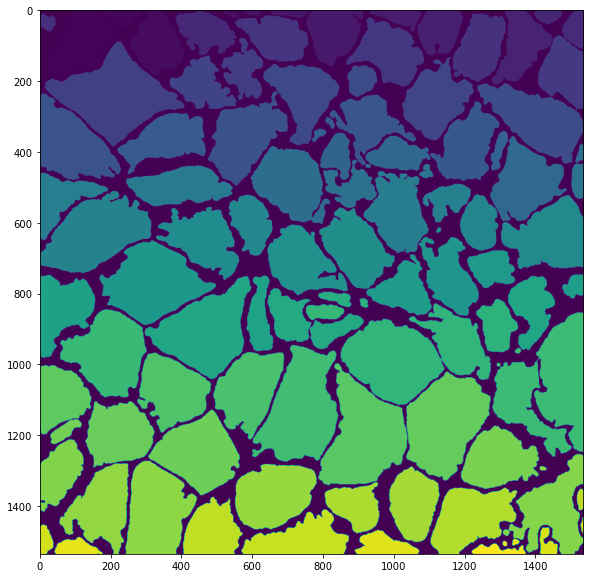

In [243]:
plt.figure(figsize=(10, 10))
plt.imshow(label_img)

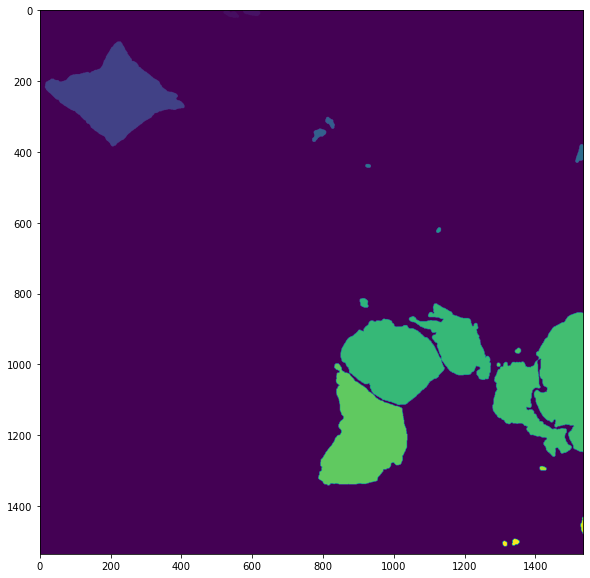

In [261]:
upper_thresh = 50000
lower_thresh = 900
discarded_blobs = (df_blobs['area'] > upper_thresh) | (df_blobs['area'] < lower_thresh)
plt.figure(figsize=(10, 10))
masked_img = label_img
masked_img[~np.isin(label_img, df_blobs.loc[discarded_blobs, 'label'].values)] = 0
plt.imshow(masked_img)

In [16]:
mi = mutual_info_classif(X, y, n_neighbors=10)
f_score, _ = f_classif(X, y)
df_tests = pd.DataFrame(np.stack((mi, f_score)).T, index=X.columns, columns=['mutual_info', 'f_score'])
df_tests

mutual_info    f_score
white_area_ratio                   0.136805  19.770762
area_median                        0.000000   0.518955
area_entropy                       0.000000   0.092104
perimeter_median                   0.000000   0.004303
perimeter_entropy                  0.000000   0.001149
...                                     ...        ...
texture_entropy_filter_median      0.084976   9.680452
texture_entropy_filter_entropy     0.168532  19.565756
global_entropy_discrete            0.050391   4.414829
global_entropy_kde                 0.054280   4.386013
global_coeff_var                   0.000000   0.254087

[90 rows x 2 columns]

In [17]:
df_tests['mutual_info_norm'] = df_tests['mutual_info'] / df_tests['mutual_info'].max()
df_tests['f_score_norm'] = df_tests['f_score'] / df_tests['f_score'].max() 
df_tests

mutual_info    f_score  mutual_info_norm  \
white_area_ratio                   0.136805  19.770762          0.669035   
area_median                        0.000000   0.518955          0.000000   
area_entropy                       0.000000   0.092104          0.000000   
perimeter_median                   0.000000   0.004303          0.000000   
perimeter_entropy                  0.000000   0.001149          0.000000   
...                                     ...        ...               ...   
texture_entropy_filter_median      0.084976   9.680452          0.415567   
texture_entropy_filter_entropy     0.168532  19.565756          0.824195   
global_entropy_discrete            0.050391   4.414829          0.246436   
global_entropy_kde                 0.054280   4.386013          0.265451   
global_coeff_var                   0.000000   0.254087          0.000000   

                                f_score_norm  
white_area_ratio                    0.863312  
area_median                         0.022661  
area_entropy                        0.004022  
perimeter_median                    0.000188  
perimeter_entropy                   0.000050  
...                                      ...  
texture_entropy_filter_median       0.422707  
texture_entropy_filter_entropy      0.854360  
global_entropy_discrete             0.192778  
global_entropy_kde                  0.191520  
global_coeff_var                    0.011095  

[90 rows x 4 columns]

In [18]:
df_tests.sort_values(by='mutual_info_norm', ascending=False).head(50)

mutual_info    f_score  \
j2j_distance_median                      0.204481  15.453869   
convexity_median                         0.199596  12.718033   
j2e_n                                    0.199149  22.901075   
convexity_>900_median                    0.192459   6.060079   
j2j_eu_distance_median                   0.176395  14.543593   
texture_entropy_filter_entropy           0.168532  19.565756   
nodes_n                                  0.167684   6.955003   
convexity_borderless_median              0.166846  13.406660   
branch_thickness_voronoi_median          0.158716  20.760325   
solidity_>900_median                     0.154925   4.825539   
compactness_>900_median                  0.149565   4.885071   
j2e_distance_median                      0.141085  18.998280   
compactness_borderless_median            0.140667  15.151217   
j2j_eu_distance_entropy                  0.138890  11.222344   
white_area_ratio                         0.136805  19.770762   
j2e_eu_distance_median                   0.129759  19.590543   
solidity_median                          0.119690   9.418247   
branch_thickness_medial_axis_median      0.119297  19.488989   
j2j_distance_entropy                     0.116732  11.454670   
solidity_borderless_median               0.110439  10.198140   
branch_thickness_medial_axis_entropy     0.109849  13.654966   
convexity_borderless_entropy             0.108618   5.068498   
j2e_distance_ratio_entropy               0.100025   6.670095   
compactness_median                       0.098053   8.008325   
branch_thickness_voronoi_entropy         0.095930  10.676324   
elongation_borderless_median             0.093911   5.411369   
texture_std_filter_median                0.090488  10.926786   
texture_std_filter_entropy               0.087698   4.920899   
texture_entropy_filter_median            0.084976   9.680452   
j2e_distance_ratio_median                0.082798  13.346066   
j2j_n                                    0.071925   5.272152   
convexity_entropy                        0.060595   4.081711   
convexity_>900_entropy                   0.058110   3.229978   
global_entropy_kde                       0.054280   4.386013   
global_entropy_discrete                  0.050391   4.414829   
elongation_borderless_entropy            0.048928   5.940507   
hull_perimeter_borderless_entropy        0.046917   0.747737   
solidity_borderless_entropy              0.045373   4.052240   
j2e_distance_entropy                     0.032563   1.246032   
elongation_median                        0.028197   2.305345   
minor_axis_length_borderless_entropy     0.026821   1.683712   
minor_axis_length_>900_entropy           0.022328   2.464900   
perimeter_borderless_entropy             0.018710   0.043546   
minor_axis_length_entropy                0.018298   2.555764   
hull_area_borderless_entropy             0.016053   0.026329   
area_borderless_entropy                  0.013965   0.007763   
j2j_distance_ratio_median                0.009607   1.263058   
compactness_entropy                      0.009297   0.318867   
hull_area_>900_median                    0.006837   1.293750   
elongation_entropy                       0.006723   0.040646   

                                      mutual_info_norm  f_score_norm  
j2j_distance_median                           1.000000      0.674810  
convexity_median                              0.976112      0.555347  
j2e_n                                         0.973923      1.000000  
convexity_>900_median                         0.941206      0.264620  
j2j_eu_distance_median                        0.862648      0.635062  
texture_entropy_filter_entropy                0.824195      0.854360  
nodes_n                                       0.820046      0.303698  
convexity_borderless_median                   0.815950      0.585416  
branch_thickness_voronoi_median               0.776191      0.906522  
solidity_>900_median                          0.757648      0.2

In [19]:
mi_threshold = 0.2
df_tests_thresh = df_tests[df_tests['mutual_info_norm'] > mi_threshold]
df_tests_thresh

mutual_info    f_score  \
white_area_ratio                         0.136805  19.770762   
compactness_median                       0.098053   8.008325   
solidity_median                          0.119690   9.418247   
convexity_median                         0.199596  12.718033   
convexity_entropy                        0.060595   4.081711   
hull_perimeter_borderless_entropy        0.046917   0.747737   
compactness_borderless_median            0.140667  15.151217   
solidity_borderless_median               0.110439  10.198140   
solidity_borderless_entropy              0.045373   4.052240   
convexity_borderless_median              0.166846  13.406660   
convexity_borderless_entropy             0.108618   5.068498   
elongation_borderless_median             0.093911   5.411369   
elongation_borderless_entropy            0.048928   5.940507   
compactness_>900_median                  0.149565   4.885071   
solidity_>900_median                     0.154925   4.825539   
convexity_>900_median                    0.192459   6.060079   
convexity_>900_entropy                   0.058110   3.229978   
j2e_n                                    0.199149  22.901075   
j2e_distance_median                      0.141085  18.998280   
j2e_eu_distance_median                   0.129759  19.590543   
j2e_distance_ratio_median                0.082798  13.346066   
j2e_distance_ratio_entropy               0.100025   6.670095   
j2j_n                                    0.071925   5.272152   
j2j_distance_median                      0.204481  15.453869   
j2j_distance_entropy                     0.116732  11.454670   
j2j_eu_distance_median                   0.176395  14.543593   
j2j_eu_distance_entropy                  0.138890  11.222344   
nodes_n                                  0.167684   6.955003   
branch_thickness_medial_axis_median      0.119297  19.488989   
branch_thickness_medial_axis_entropy     0.109849  13.654966   
branch_thickness_voronoi_median          0.158716  20.760325   
branch_thickness_voronoi_entropy         0.095930  10.676324   
texture_std_filter_median                0.090488  10.926786   
texture_std_filter_entropy               0.087698   4.920899   
texture_entropy_filter_median            0.084976   9.680452   
texture_entropy_filter_entropy           0.168532  19.565756   
global_entropy_discrete                  0.050391   4.414829   
global_entropy_kde                       0.054280   4.386013   

                                      mutual_info_norm  f_score_norm  
white_area_ratio                              0.669035      0.863312  
compactness_median                            0.479523      0.349692  
solidity_median                               0.585336      0.411258  
convexity_median                              0.976112      0.555347  
convexity_entropy                             0.296334      0.178232  
hull_perimeter_borderless_entropy             0.229447      0.032651  
compactness_borderless_median                 0.687922      0.661594  
solidity_borderless_median                    0.540096      0.445313  
solidity_borderless_entropy                   0.221892      0.176945  
convexity_borderless_median                   0.815950      0.585416  
convexity_borderless_entropy                  0.531188      0.221321  
elongation_borderless_median                  0.459266      0.236293  
elongation_borderless_entropy                 0.239277      0.259399  
compactness_>900_median                       0.731439      0.213312  
solidity_>900_median                          0.757648      0.210712  
convexity_>900_median                         0.941206      0.264620  
convexity_>900_entropy                        0.284182      0.141040  
j2e_n                                         0.973923      1.000000  
j2e_distance_median                           0.689968      0.829580  
j2e_eu_distance_median                        0.634575      0.855442  
j2e_distance_ratio_median                     0.40

In [16]:
df_tests_thresh.sort_values('mutual_info_norm', ascending=False).head(40)

mutual_info    f_score  mutual_info_norm  \
j2j_distance_median                     0.204481  15.453869          1.000000   
convexity_>900_mad                      0.203955   4.651773          0.997429   
j2e_n                                   0.201459  22.901075          0.985220   
convexity_borderless_mean               0.200407  12.377157          0.980074   
convexity_median                        0.199596  12.718033          0.976112   
convexity_mad                           0.193028   4.874728          0.943988   
convexity_>900_median                   0.192459   6.060079          0.941206   
convexity_mean                          0.186233   9.937182          0.910757   
branch_thickness_voronoi_mean           0.180971  20.736773          0.885025   
j2j_eu_distance_mean                    0.179887  13.939248          0.879722   
j2j_eu_distance_median                  0.176395  14.543593          0.862648   
compactness_>900_mean                   0.174654   3.619658          0.854132   
j2j_distance_mean                       0.170676  14.215748          0.834680   
texture_entropy_filter_entropy          0.168532  19.565756          0.824195   
nodes_n                                 0.167655   6.955003          0.819904   
convexity_>900_mean                     0.167237   4.455454          0.817859   
convexity_borderless_median             0.166846  13.406660          0.815950   
convexity_borderless_mad                0.163033   3.102893          0.797301   
j2e_distance_mode                       0.162290  11.515910          0.793670   
compactness_borderless_mean             0.159122  20.502705          0.778176   
texture_entropy_filter_mad              0.157388  13.682080          0.769694   
branch_thickness_medial_axis_mean       0.157192  16.687876          0.768738   
solidity_>900_median                    0.154925   4.825539          0.757648   
branch_thickness_voronoi_median         0.154365  20.760325          0.754911   
compactness_borderless_mode             0.150611  14.315375          0.736553   
compactness_>900_median                 0.149565   4.885071          0.731439   
j2j_distance_mad                        0.146461  16.193763          0.716259   
j2j_eu_distance_mad                     0.144166  13.931501          0.705033   
j2e_distance_median                     0.141085  18.998280          0.689968   
compactness_borderless_median           0.140667  15.151217          0.687922   
j2j_eu_distance_entropy                 0.138890  11.222344          0.679232   
white_area_ratio                        0.136805  19.770762          0.669035   
j2e_eu_distance_median                  0.129759  19.590543          0.634575   
branch_thickness_medial_axis_median     0.128494  19.488989          0.628391   
j2e_eu_distance_mode                    0.124052  12.407236          0.606668   
branch_thickness_voronoi_mad            0.123804   6.748147          0.605452   
texture_entropy_filter_std              0.122318  16.315817          0.598188   
texture_std_filter_mode                 0.120089  16.270980          0.587286   
solidity_median                         0.119690   9.418247          0.585336   
j2j_distance_entropy                    0.116732  11.454670          0.570870   

                                     f_score_norm  
j2j_distance_median                      0.674810  
convexity_>900_mad                       0.203125  
j2e_n                                    1.000000  
convexity_borderless_mean                0.540462  
convexity_median                         0.555347  
convexity_mad                            0.212860  
convexity_>900_median                    0.264620  
convexity_mean                           0.433918  
branch_thickness_voronoi_mean            0.905493  
j2j_eu_distance_mean                     0.608672  
j2j_eu_distance_median                   0.635062  
compactness_>900_mean                    0.158056  
j2j_distance_mean                      

In [17]:
X = X[df_tests_thresh.index]
backup = X

In [18]:
X[['white_area_ratio', 'convexity_median']]

white_area_ratio  convexity_median
NegsiRNA_E3_NO          0.297828          0.933102
NegsiRNA_L2_NS          0.188984          0.924152
NegsiRNA_H3_NO          0.331324          0.945185
NegsiRNA_G3_NS          0.239506          0.953916
NegsiRNA_B1_NO          0.334231          0.953457
...                          ...               ...
NegsiRNA_I2_NO          0.294810          0.941260
NegsiRNA_G3_NO          0.308489          0.920725
NegsiRNA_A1_NO          0.298644          0.938238
NegsiRNA_I3_NO          0.287247          0.940686
NegsiRNA_H3_NS          0.287646          0.954759

[68 rows x 2 columns]

In [20]:
X = backup
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_features='sqrt', n_estimators=2000, oob_score=True,
                       random_state=0)

In [104]:
predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

              precision    recall  f1-score   support

          NO       0.76      0.82      0.79        34
          NS       0.81      0.74      0.77        34

    accuracy                           0.78        68
   macro avg       0.78      0.78      0.78        68
weighted avg       0.78      0.78      0.78        68



<AxesSubplot:>

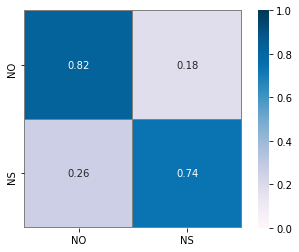

In [105]:
cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

(<Figure size 3024x432 with 1 Axes>, <AxesSubplot:>)

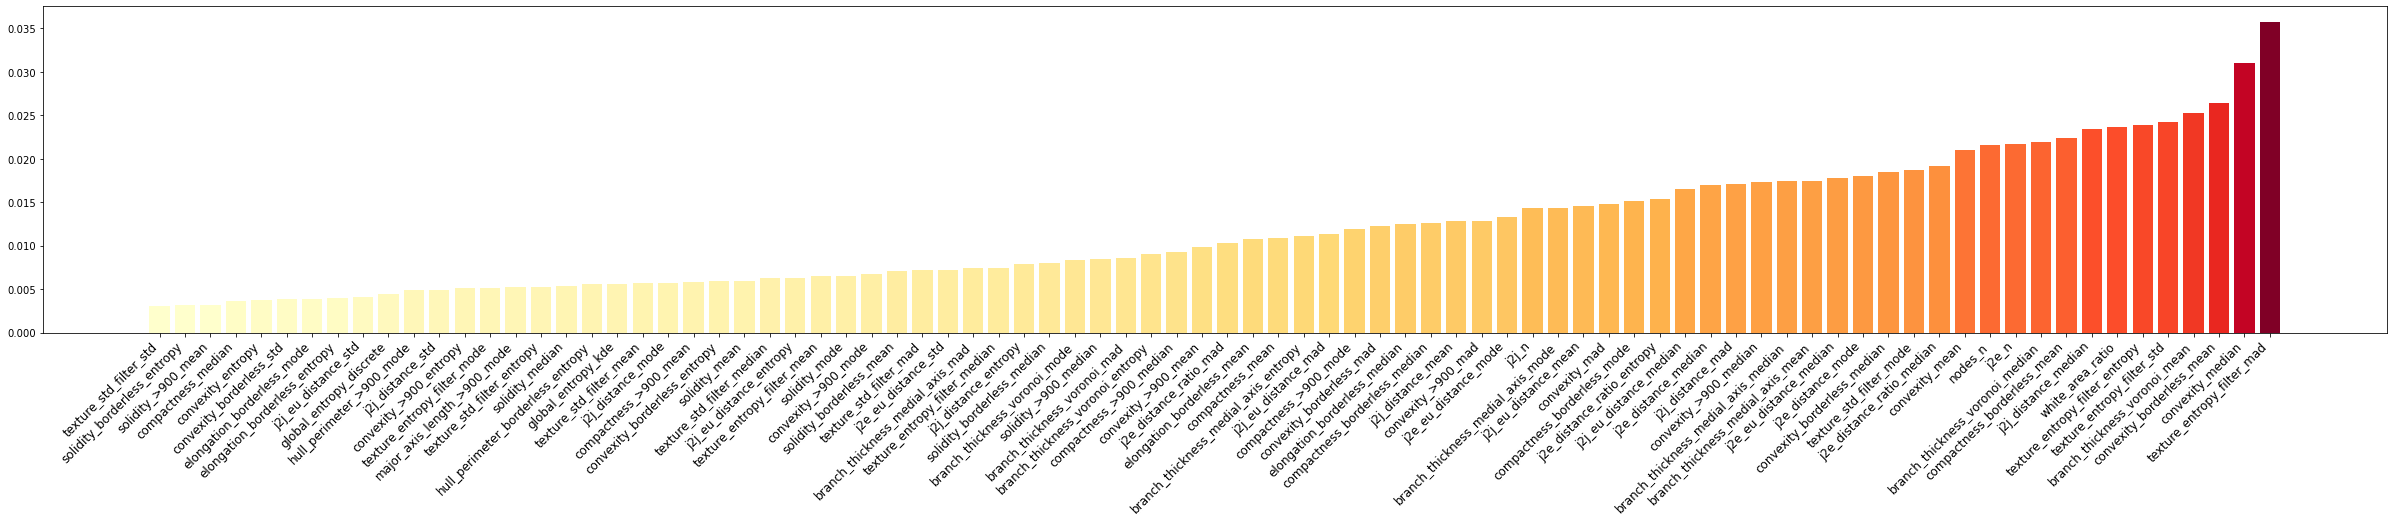

In [106]:
plot_ft_importance(clf, X.columns)

In [ ]:
Exclude small ones for nuclei_blobs_ratio
3 analysis: all blobs, borderless, no small ones

In [ ]:
utils.